# BI-PRS - Semestral work 3

In [1]:
# Dataset selection according to the represant's data
K <- 27
L <- nchar('bardatskii')
M <- ((K + L) * 47) %% 11 + 1

cat('Parameter M =', M, '=> Kamil Dedecius')
cat('\nYear =', 2011 + M)

Parameter M = 2 => Kamil Dedecius
Year = 2013

In [2]:
# TODO: lexicographical order

# Neccessary imports
library(eurostat)
library(car)
library(cowplot)
library(tseries)
library(lmtest)
library(countrycode)
library(stringr)
library(ggplot2)
library(gridExtra)
library(psych)
library(olsrr)
library(corrplot)

Loading required package: carData

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


The following object is masked from ‘package:car’:

    logit



Attaching package: ‘olsrr’


The following object is masked from ‘package:datasets’:

    rivers


corrplot 0.92 loaded



## Abstract

The project examines the [**Gross Domestic Product (GDP)**](https://www.investopedia.com/terms/g/gdp.asp) of **European countries** in **2013**. The study investigates [**nominal GDP per capita**](https://www.investopedia.com/terms/n/nominalgdp.asp) in particular.

**Table of contents:**
- Dataset preparation
- GDP elucidation
- Regressors selection
- Dependencies visualization
- Statistical tests
- Linear model
- Outliers
- Multicollinearity
- Model Premises Tests
- Final Model

## Data preparation

In [3]:
# Load the dataset
data <- get_eurostat(id='nama_10_pc')
head(data, 5)

Table nama_10_pc cached at /tmp/RtmpzktYRe/eurostat/11b065fd45a1428b085c6e9d6e760f22.rds



freq,unit,na_item,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,CLV10_EUR_HAB,B1GQ,AL,1995-01-01,1310
A,CLV10_EUR_HAB,B1GQ,AL,1996-01-01,1410
A,CLV10_EUR_HAB,B1GQ,AL,1997-01-01,1270
A,CLV10_EUR_HAB,B1GQ,AL,1998-01-01,1390
A,CLV10_EUR_HAB,B1GQ,AL,1999-01-01,1580


Transform the dataset, leaving only **Gross Domestic Product per capita** in euros in **2013** for individual European countries.

In [4]:
colnames(data)[4] <- 'country'  # rename "geo" column
colnames(data)[6] <- 'GDPpc'    # rename "values" column
data <- subset(data,
               na_item == 'B1GQ' &     # Gross domestic product at market prices
               unit == 'CP_EUR_HAB' &  # Current prices, euro per capita
               TIME_PERIOD == '2013-01-01' &
               !(country %in% c(
                   'EU27_2020',  # European Union - 27 countries (from 2020)
                   'EU28',       # European Union - 28 countries (2013-2020)
                   'EU15',       # European Union - 15 countries (1995-2004)
                   'EA',         # Euro area
                   'EA20',       # Euro area – 20 countries (from 2023)
                   'EA19',       # Euro area - 19 countries  (2015-2022)
                   'EA12'        # Euro area - 12 countries (2001-2006)
               )),
               c(country, GDPpc))
data$country <- countrycode(data$country, 'eurostat', 'country.name')
data$country <- factor(data$country)
head(data, 3)

country,GDPpc
<fct>,<dbl>
Albania,3320
Austria,38210
Belgium,35210


In [5]:
any(is.na(data$GDPpc)) # Check for NA values

[1] FALSE

## GDP elucidation

Analyze the `GDPpc` using statistical metrics and visualizations.

In [6]:
describe(data$GDPpc, ranges=F, quant=c(0.25, 0.5, 0.75), IQR=T)[, -1]

,n,mean,sd,skew,kurtosis,se,IQR,Q0.25,Q0.5,Q0.75
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,37,28576.49,26468.96,1.873744,3.839155,4351.471,27700,10480,18680,38180


Skewness and the strong deviation of the mean from the median indicate the presence of an *“eastern”* tail in the distribution. Let's check it out on the histogram.

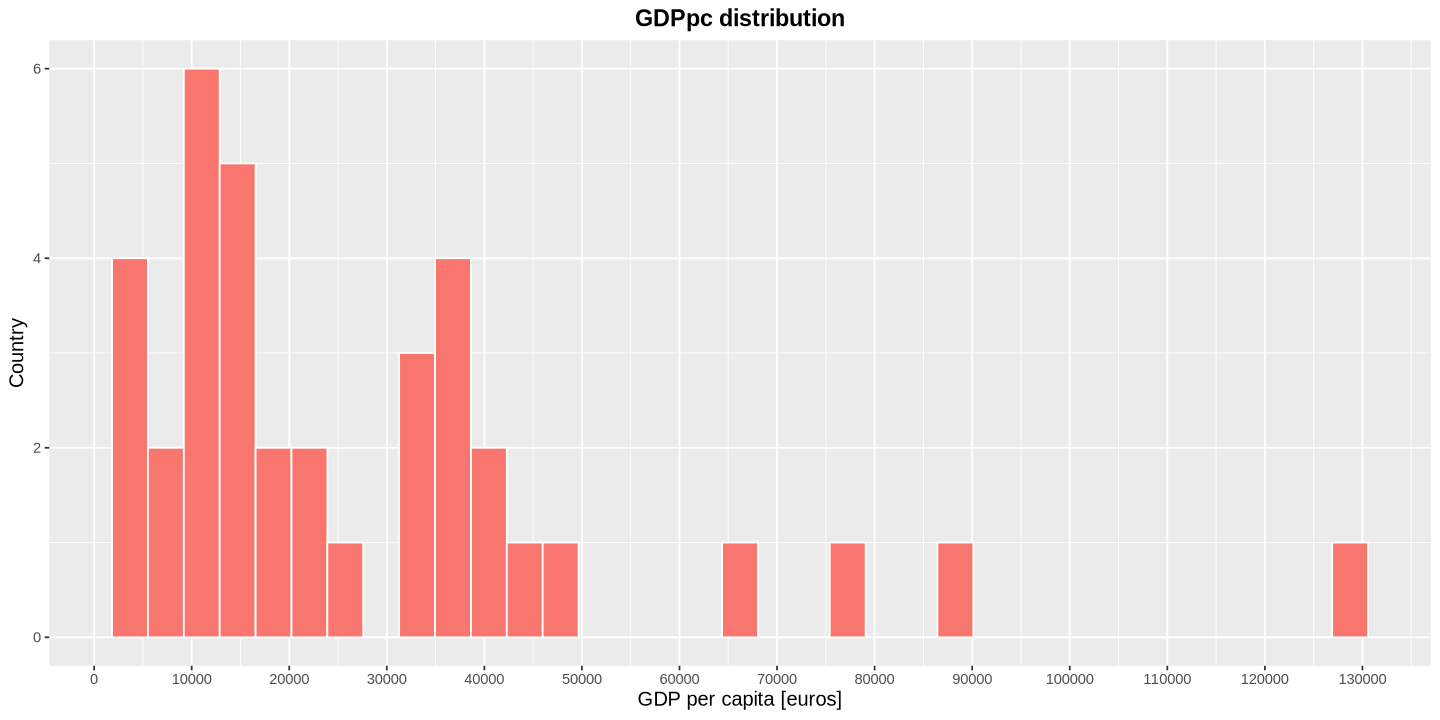

In [7]:
options(repr.plot.width=12, repr.plot.height=6)                        # figure settings 

ggplot(data, aes(x=GDPpc)) +                                           
  geom_histogram(bins=35, fill='#f8766d', col='white') +               # hist
  labs(title='GDPpc distribution',                                     # labels        
       x='GDP per capita [euros]',
       y='Country') + 
  scale_x_continuous(breaks=scales::pretty_breaks(n=12)) +             # set x axis ticks
  theme(
    plot.title = element_text(hjust = 0.5, size=14, face="bold"),      # center and style the title
    axis.title = element_text(size=12),                                # axis title size
  )

As expected, the distribution has a tail. Several countries have a much higher `GDPpc` than the rest.

In addition, three potential clusters can be noticed in the graph: 

1. $\mathrm{GDPpc} \le 30000$,
2. $30000 < \mathrm{GDPpc} \le 60000$,
3. $60000 < \mathrm{GDPpc}$.

Each of these clusters may be amenable to its own distribution.

## Regressors selection

[Many factors](https://www.investopedia.com/articles/investing/051415/how-calculate-gdp-country.asp) can affect the GDP per capita and a country's economy. Below we offer three variants of a continuous variable and one binary. [Human Development Report](https://en.wikipedia.org/wiki/Human_Development_Report) will be a data source for regressors. [(link)](https://hdr.undp.org/data-center/documentation-and-downloads)

### Continuous regressors

In [8]:
# Load the dataset
extra_src_url <- 'https://hdr.undp.org/sites/default/files/2023-24_HDR/HDR23-24_Composite_indices_complete_time_series.csv'

In [9]:
extra_data <- read.csv(url(extra_src_url), encoding='UTF-8')
extra_data$country <- str_replace(extra_data$country, 'T\xfcrkiye', 'Turkey')
head(extra_data, 5)

,iso3,country,hdicode,region,hdi_rank_2022,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,⋯,pop_total_2013,pop_total_2014,pop_total_2015,pop_total_2016,pop_total_2017,pop_total_2018,pop_total_2019,pop_total_2020,pop_total_2021,pop_total_2022
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AFG,Afghanistan,Low,SA,182,0.284,0.292,0.299,0.307,0.300,⋯,31.5412085,32.7162100,33.7534990,34.6362075,35.6434175,36.6867840,37.769498,38.972231,40.099462,41.128771
2,ALB,Albania,High,ECA,74,0.649,0.632,0.616,0.618,0.623,⋯,2.8870140,2.8841020,2.8824805,2.8810630,2.8793550,2.8770130,2.873883,2.866849,2.854710,2.842321
3,DZA,Algeria,High,AS,93,0.593,0.596,0.601,0.602,0.603,⋯,38.0006265,38.7601675,39.5431545,40.3393285,41.1365460,41.9270070,42.705368,43.451666,44.177968,44.903225
4,AND,Andorra,Very High,,35,NA,NA,NA,NA,NA,⋯,0.0713665,0.0716215,0.0717455,0.0725405,0.0738365,0.0750135,0.076343,0.077700,0.079034,0.079824
5,AGO,Angola,Medium,SSA,150,NA,NA,NA,NA,NA,⋯,26.1470020,27.1283365,28.1277210,29.1547455,30.2086280,31.2735330,32.353588,33.428486,34.503774,35.588987


In [10]:
# Check if the additional dataset has all countries required
all(data$country %in% extra_data$country)

[1] TRUE

Only some features are needed, which are:
- `LE`: Life Expectancy at Birth (years)
- `MYS`: Mean Years of Schooling (years)
- `EYS`: Expected Years of Schooling (years)
- `GNIpc`: Gross National Income Per Capita (2017 PPP$)
*all for 2013

In [11]:
extra_data <- subset(extra_data,
       country %in% data$country,
       c(
           'country',
           'le_2013',  # Life Expectancy at Birth [years] ~ LE
           'mys_2013',  # Mean Years of Schooling [years] ~ MYS
           'eys_2013',  # Expected Years of Schooling [years] ~ EYS
           'gnipc_2013'  # Gross National Income Per Capita [2017 PPP$] ~ GNIpc
       ))

In [12]:
any(is.na(extra_data)) # Check for NA values

[1] FALSE

In [13]:
data <- merge(data, extra_data, by='country') # Merge the datasets

The indicators in one way or another related to the [Human Development Index](https://en.wikipedia.org/wiki/Human_Development_Index) were taken as a basis.

First of all, let's look at how HDI is calculated:

1. **Life Expectancy Index**: $\mathrm{LEI} = \frac{\mathrm{LE} - 20}{65}$
2. **Education Index**: $\mathrm{EI} = \frac{\frac{\mathrm{MYS}}{15} + \frac{\mathrm{EYS}}{18}}{2}$
3. **Income Index**: $\mathrm{II} = \frac{\ln(\mathrm{GNIpc}) - \ln(100)}{\ln(750)}$
4. **Human Development Index**: $\mathrm{HDI} = \sqrt[3]{\mathrm{LEI} \cdot \mathrm{EI} \cdot \mathrm{II}}$

Instead of using HDI itself, we take its components. However, just taking the presented indexes is not a good idea. Let's see why.

The problem with using LEI is that its values are much more difficult to interpret than LE values. As a consequence, we leave LE untouched.

GNIpc is calculated using the following formula$$\mathrm{GNIpc} = \mathrm{GDPpc} + \mathrm{NFIApc},$$where NFIApc is **Net Factor Income from Abroad per capita** and is calculated as$$\mathrm{NFIApc} = \frac{\text{Money flowing from foreign countries} - \text{Money flowing to foreign countries}}{\text{Population}}.$$

Since GNIpc already contains GDPpc, using it would mean that our model would implicitly learn to predict NFIApc. This is not quite the right approach to the problem at hand. Therefore, we only take NFIApc as a regressor. However, we cannot simply subtract euro GDPpc from dollar GNIpc, we need to convert GNIpc into euros beforehand. For this purpose we use [this](https://www.exchangerates.org.uk/EUR-USD-spot-exchange-rates-history-2013.html#:~:text=Average%20exchange%20rate%20in%202013%3A%201.3284%20USD.) exchange rate.

In [14]:
data$LE <- data$le_2013
data$EI <- (data$mys_2013 / 15 + data$eys_2013 / 18) / 2
data$NFIApc <- data$gnipc_2013 / 1.3284 - data$GDPpc
data <- data[, c('country', 'GDPpc', 'LE', 'EI', 'NFIApc')]
head(data, 5)

,country,GDPpc,LE,EI,NFIApc
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,Albania,3320,78.123,0.7781896,5376.903
2,Austria,38210,81.078,0.8383914,1791.626
3,Belgium,35210,80.468,0.9221770,1962.076
4,Bulgaria,5790,74.849,0.7824033,8144.946
5,Croatia,10480,77.843,0.8044435,7332.921


#### Binary factor

The factor of the country's entry into the [Blue Banana](https://en.wikipedia.org/wiki/Blue_Banana) area was chosen as a binary predictor. The intuition behind this decision is based on the fact that the cities within this zone are of great economic importance.

Here's a [**link**](https://en.wikipedia.org/wiki/Blue_Banana) to the data source.

In [15]:
data$BB_entry <- (data$country %in% c(
    'Austria',
    'Belgium',
    'France',
    'Germany',
    'Italy',
    'Luxembourg',
    'Netherlands',
    'United Kingdom',
    'Liechtenstein',
    'Switzerland'
))

head(data, 5)

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,Albania,3320,78.123,0.7781896,5376.903,FALSE
2,Austria,38210,81.078,0.8383914,1791.626,TRUE
3,Belgium,35210,80.468,0.9221770,1962.076,TRUE
4,Bulgaria,5790,74.849,0.7824033,8144.946,FALSE
5,Croatia,10480,77.843,0.8044435,7332.921,FALSE


## Data Visualization

In [16]:
# prepare common parameters and styles
text <- geom_text(aes(label=country), size=3, vjust=-1, hjust=0.5)
scale <- scale_y_continuous(breaks=scales::pretty_breaks(n=5))
theme <- theme(
        plot.title = element_text(hjust = 0.5, size=14, face="bold"),      # center and style the title
        axis.title = element_text(size=12),                                # axis title size
    )

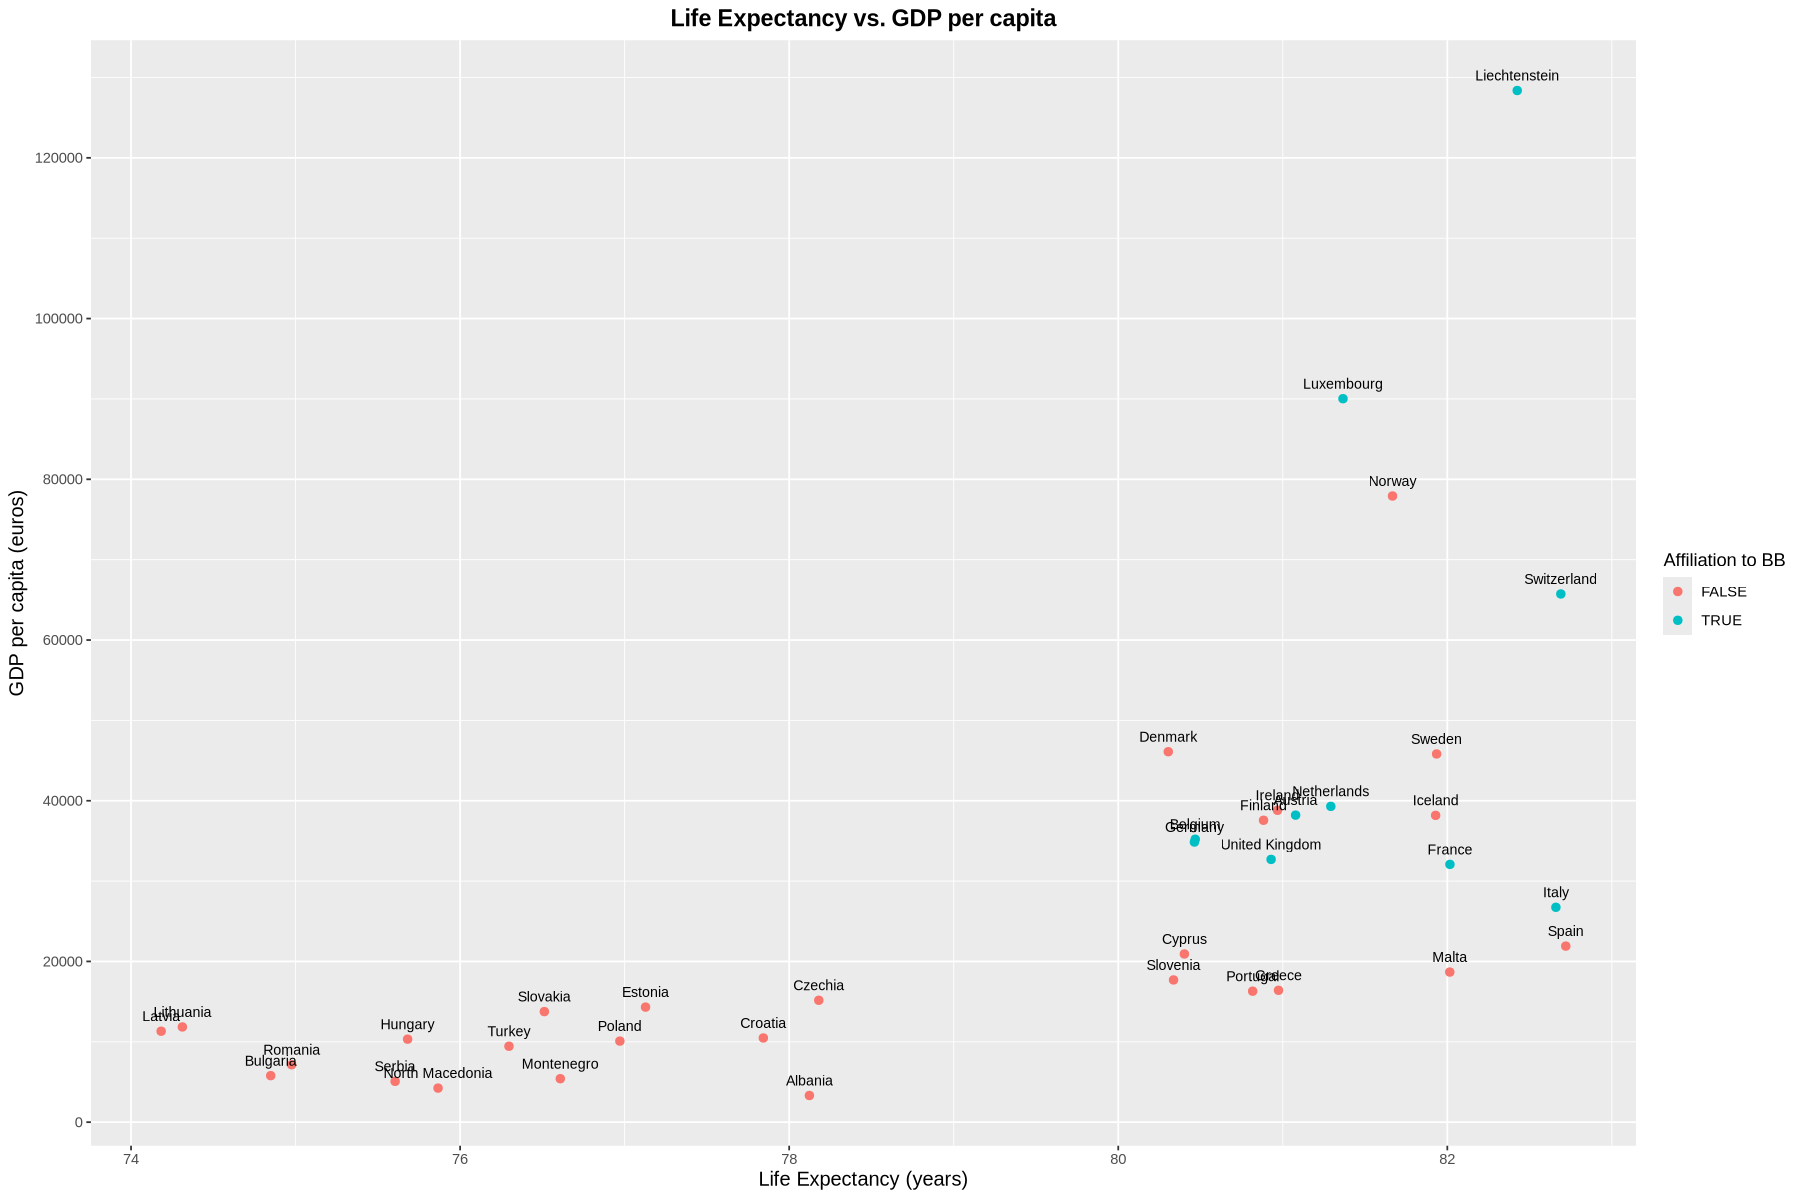

In [17]:
options(repr.plot.width=15, repr.plot.height=10)                        # figure settings 

# save labs for later use for the same scatter plot in different contexts
labs_le <- labs(title='Life Expectancy vs. GDP per capita',                     # labels
               x='Life Expectancy (years)',
               y='GDP per capita (euros)',
               color='Affiliation to BB')
    
ggplot(data, aes(x=LE, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) +                                    
  labs_le + text + scale + theme

- The plot helps visualize economic disparities and their potential impact on life expectancy across different countries.
- There is a visible trend where countries with higher GDP per capita and affiliation to BB generally have higher life expectancies.

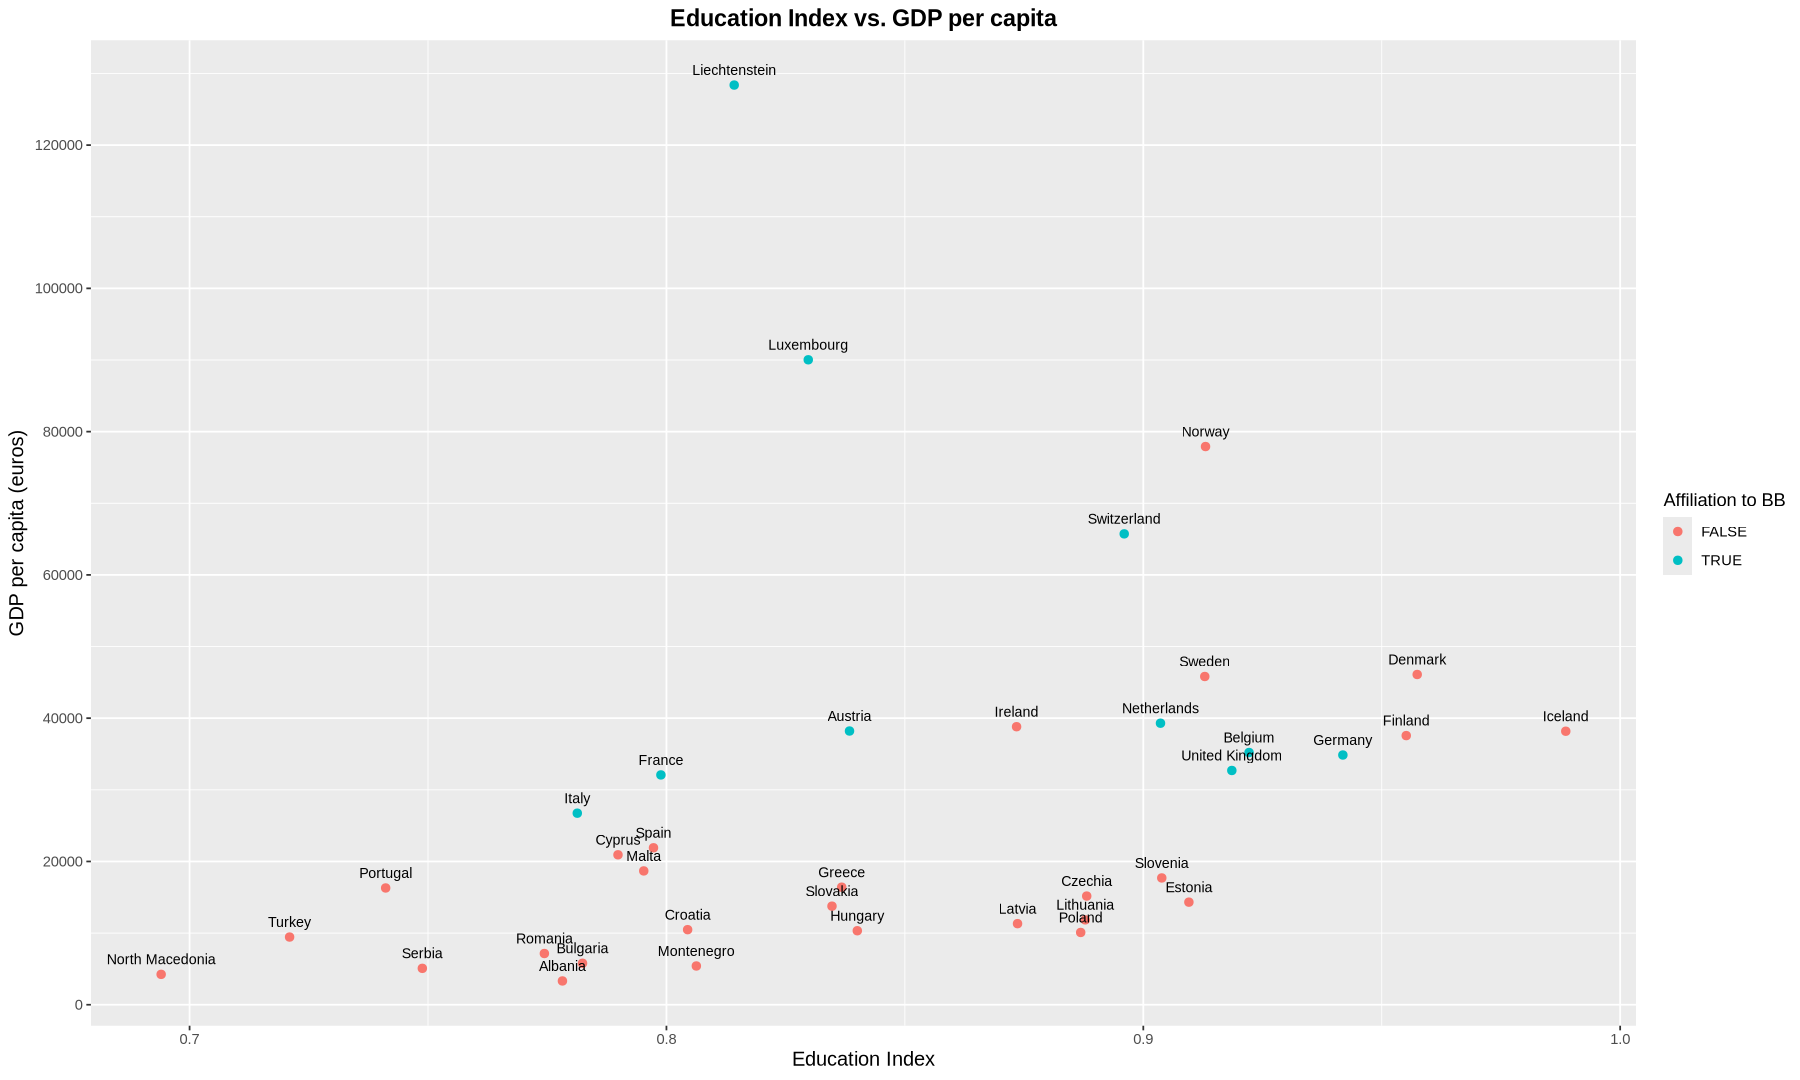

In [18]:
options(repr.plot.width=15, repr.plot.height=9)                        # figure settings 

labs_ei <- labs(title='Education Index vs. GDP per capita',                     # labels
               x='Education Index',
               y='GDP per capita (euros)',
               color='Affiliation to BB')

ggplot(data, aes(x=EI, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) + 
  labs_ei + text + scale + theme

- There is a general trend showing that countries with higher Education Index scores tend to have higher GDP per capita.
- Outliers like Liechtenstein and Luxembourg have exceptionally high GDP per capita compared to their Education Index.
- Countries with lower Education Index scores (around 0.7 to 0.8) generally have lower GDP per capita, such as North Macedonia, Turkey, and Serbia.

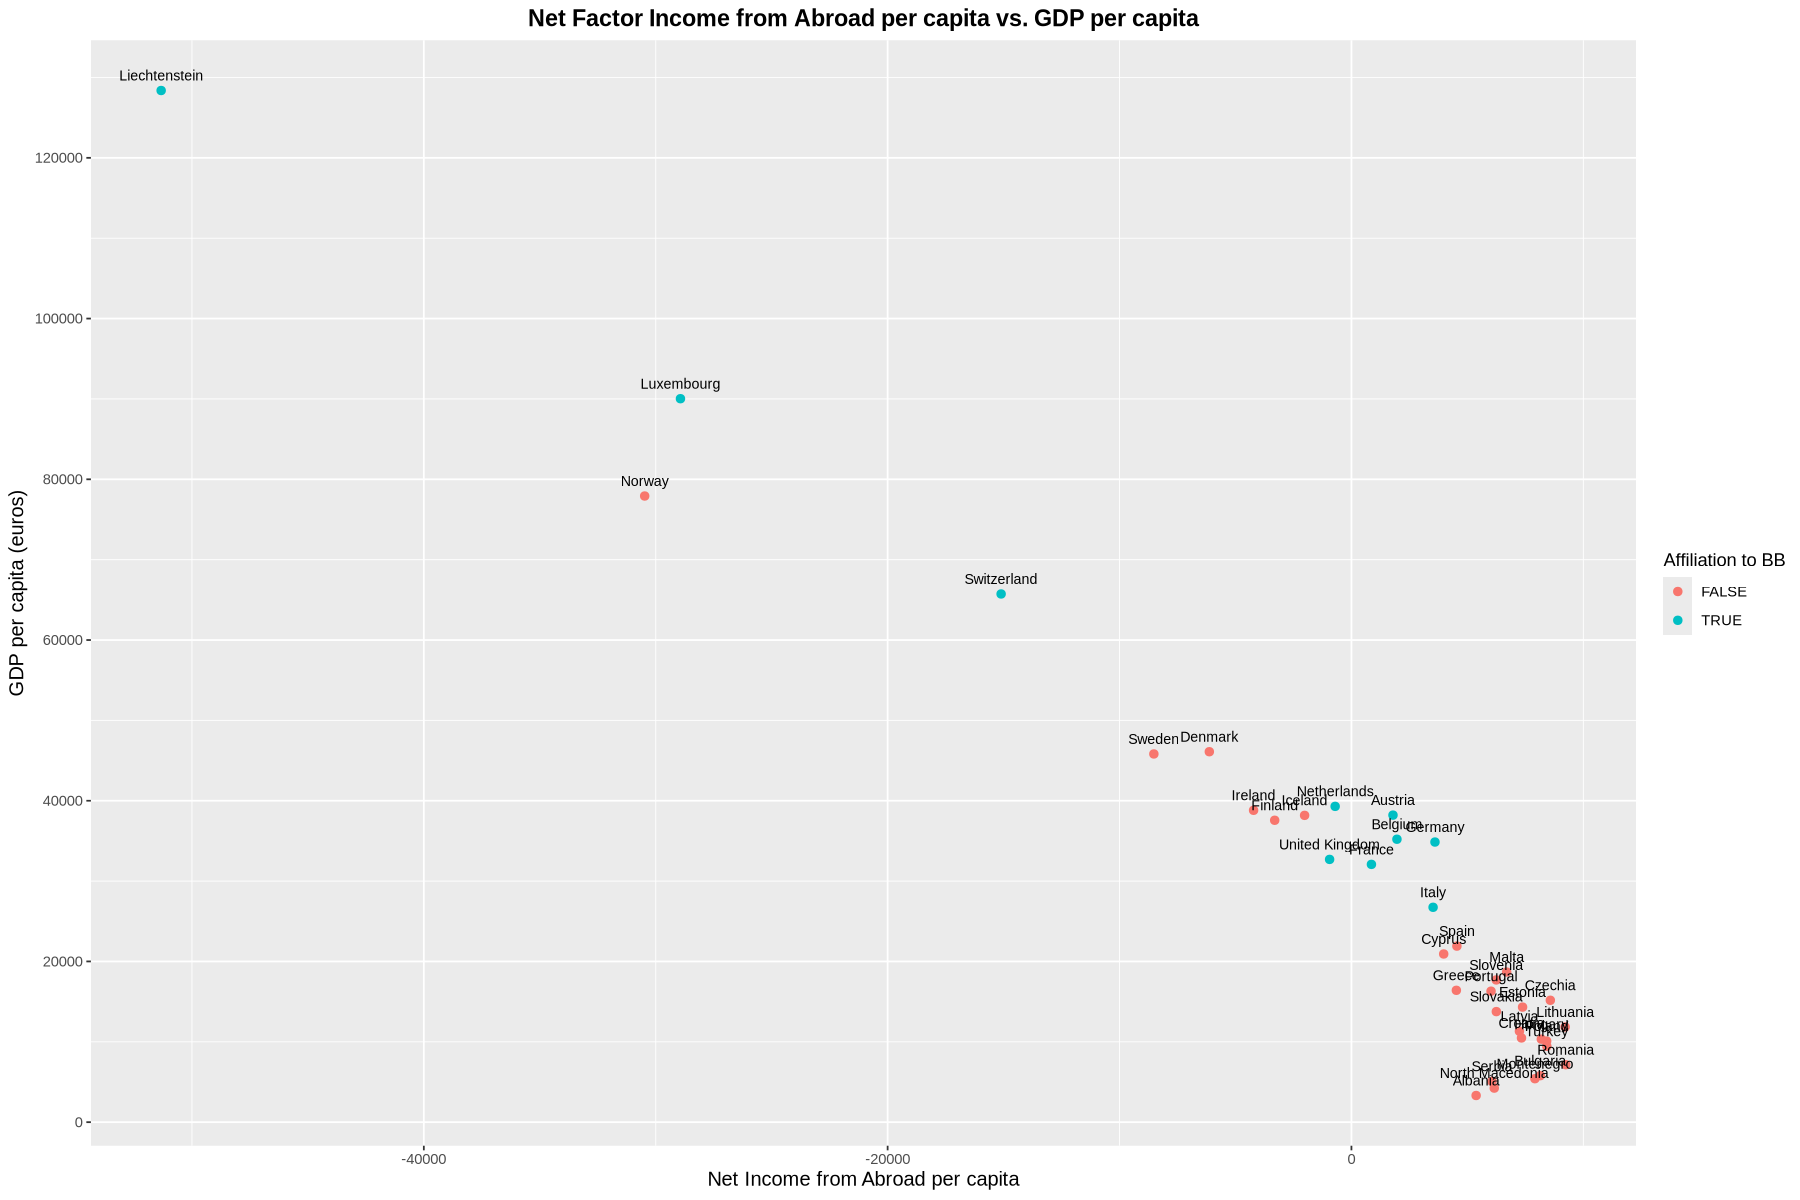

In [19]:
options(repr.plot.width=15, repr.plot.height=10)                        # figure settings 
labs_nfiapc <- labs(title='Net Factor Income from Abroad per capita vs. GDP per capita',   # labels
                   x='Net Income from Abroad per capita',
                   y='GDP per capita (euros)',
                   color='Affiliation to BB')

ggplot(data, aes(x=NFIApc, y=GDPpc)) +
  geom_point(aes(col=BB_entry), size=2) +
  labs_nfiapc + text + scale + theme

- Liechtenstein, Luxembourg, and Norway are notable outliers with high GDP per capita despite negative or zero Net Income from Abroad per capita.
- Most countries cluster around lower GDP per capita values and with low positive Net Income from Abroad per capita.
- The majority of countries have positive Net Income from Abroad per capita, but there are a lot of countries with negative values, suggesting that they spend more abroad than they receive.

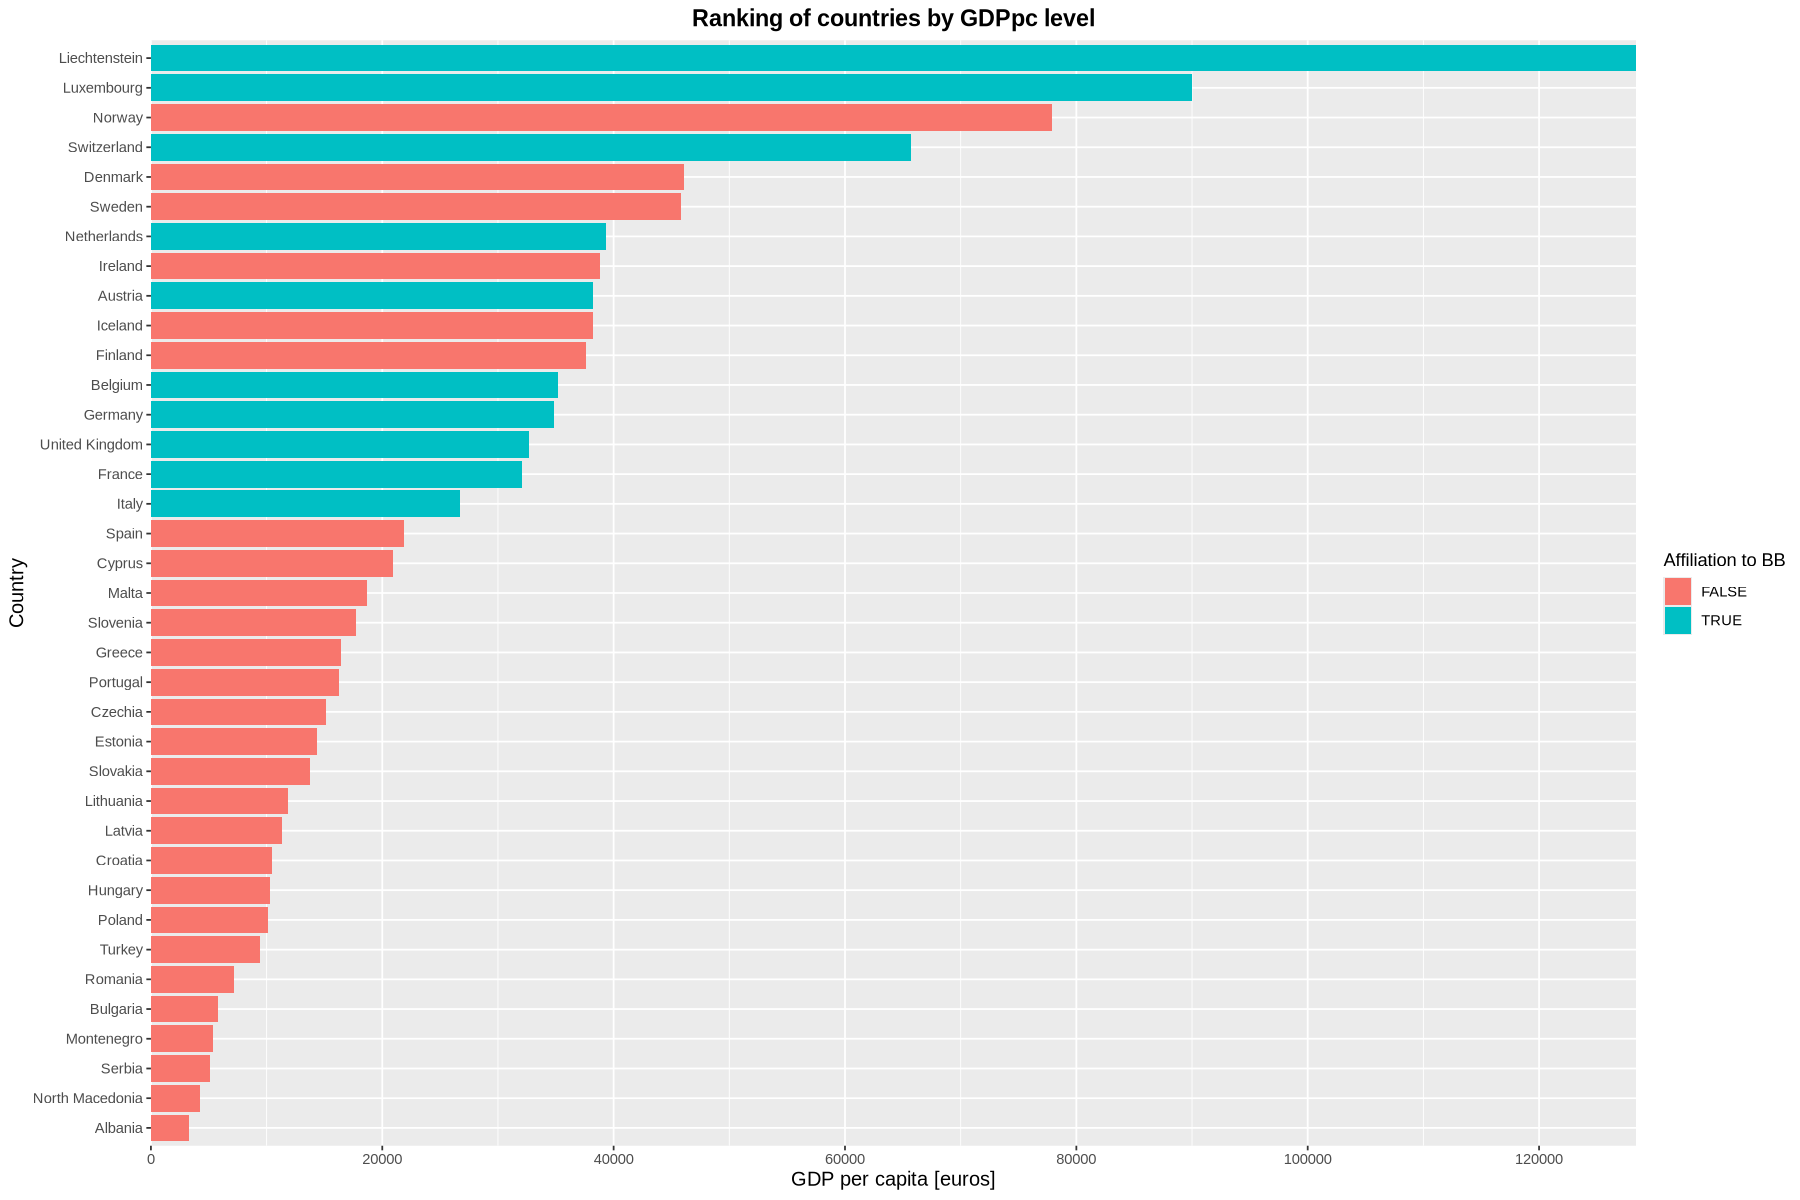

In [20]:
options(repr.plot.width=15, repr.plot.height=10)                        # figure settings 

ggplot(data, aes(x=GDPpc, y=reorder(country, GDPpc), fill=BB_entry)) +
  geom_bar(stat='identity') +
  labs(title='Ranking of countries by GDPpc level',
       x='GDP per capita [euros]',
       y='Country',
       fill='Affiliation to BB') +
  scale_x_continuous(breaks=scales::pretty_breaks(n=6), expand=c(0, 0)) + theme

- Top Performers: Liechtenstein, Luxembourg, and Norway are at the top of the list, having the highest GDP per capita.
- Mid-range Performers: Countries like Germany, the United Kingdom, and France are in the middle range, with moderate GDP per capita levels.
- Lower Performers: Countries like Albania, North Macedonia, and Serbia are at the bottom, with the lowest GDP per capita.
- Countries that are listed in BB are placed only in best performing half of the countries presented.

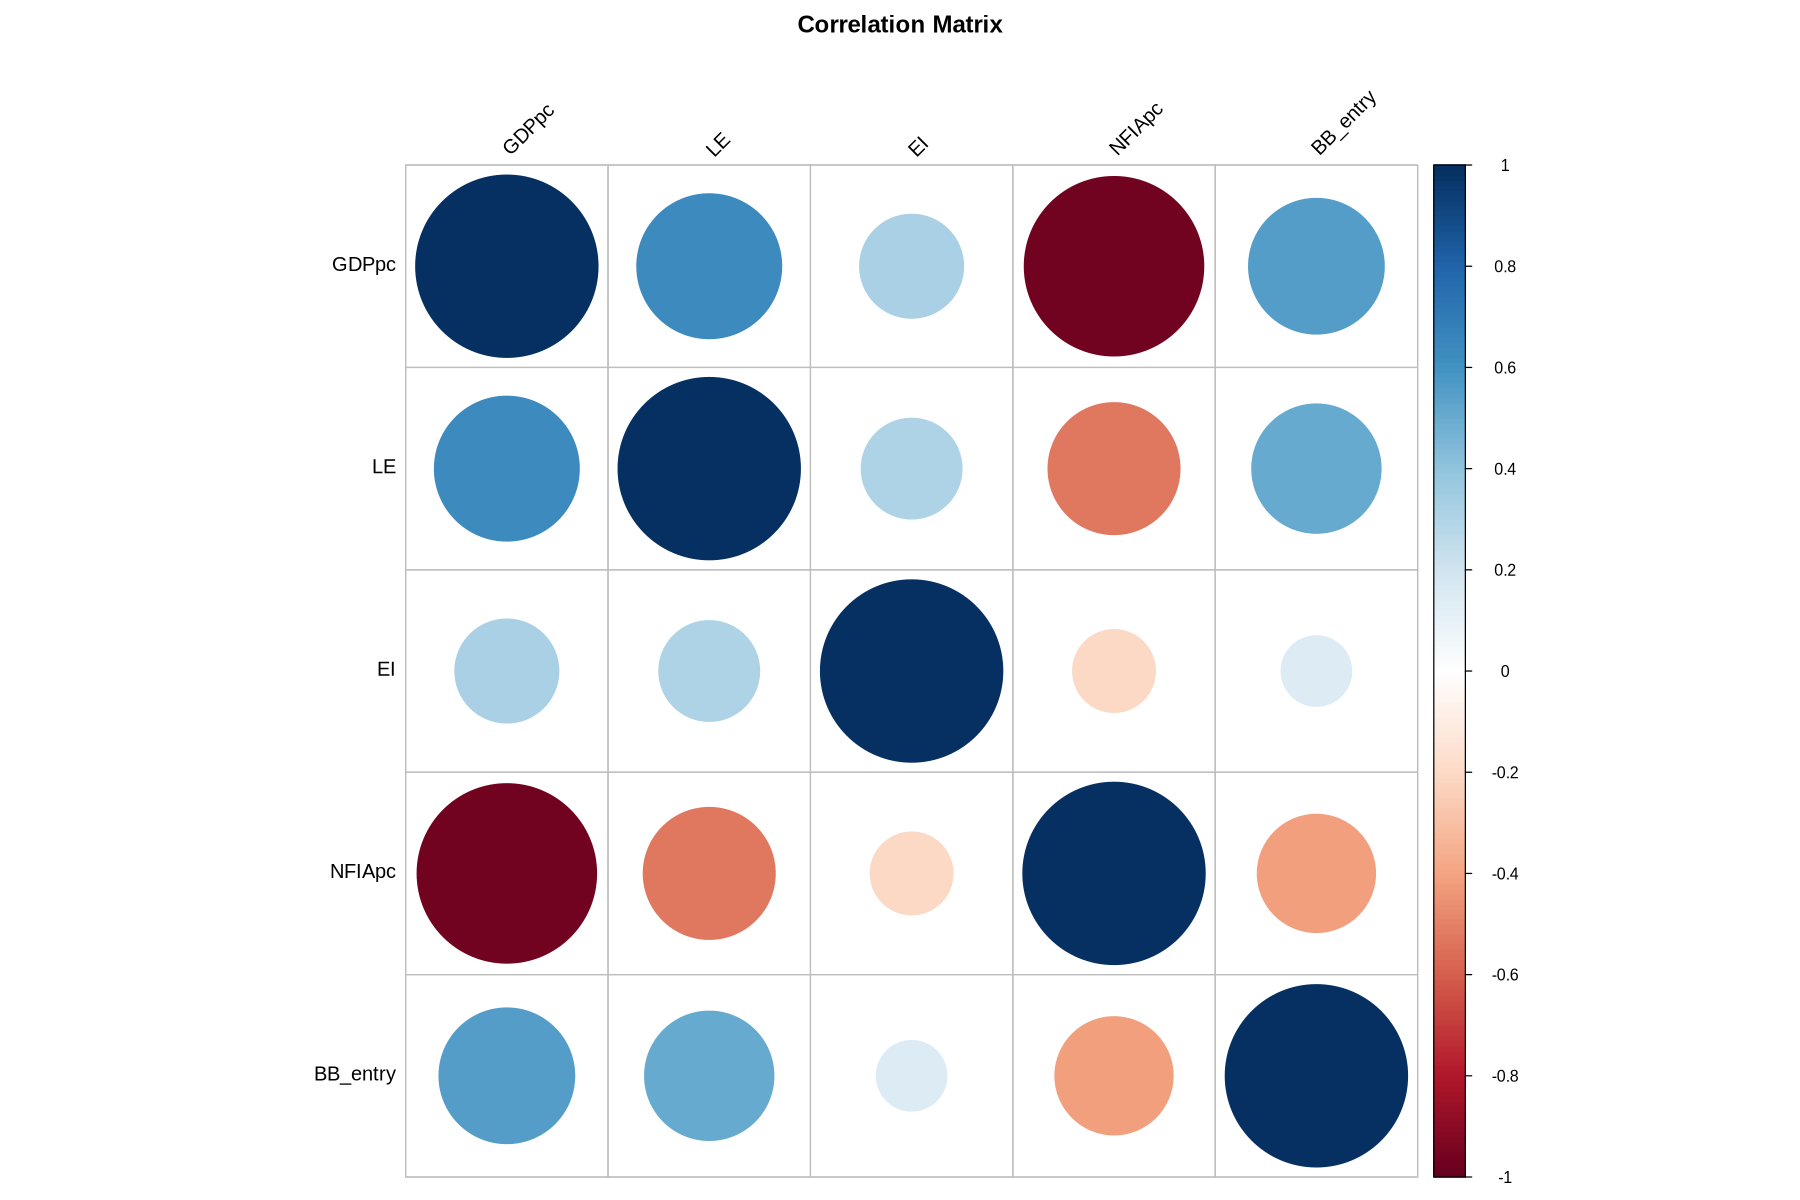

In [21]:
corrplot(cor(data[, -1]), method="circle", 
         tl.col="black", tl.srt=45, 
         title="Correlation Matrix", mar=c(0,0,2,0))

- GDPpc and LE: There is a strong positive correlation between GDP per capita and Life Expectancy, suggesting that higher economic output per person is associated with longer life expectancy.
- NFIapc and GDPpc: There is a strong negative correlation between Net Foreign Income per capita and GDP per capita, suggesting that countries with high GDP per capita tend to have lower net foreign income per capita.
- NFIapc and LE: Similarly, there is a negative correlation between Net Foreign Income per capita and Life Expectancy.

## Tests

In [22]:
# ??????

## Linear model

First of all, we will try a model with all features and assess its quality. After that we will try to understand non-linear relationships between target variable and independent variables.

### Simple Linear Model

We try a simple linear model with all regressors without use of functions:

In [23]:
model <- lm(GDPpc ~ LE + EI + NFIApc + BB_entry, data = data)
summary(model)


Call:
lm(formula = GDPpc ~ LE + EI + NFIApc + BB_entry, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-10321.8  -1413.9      4.2   2483.4   5292.1 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -7.238e+04  2.214e+04  -3.269 0.002581 ** 
LE            8.414e+02  2.869e+02   2.933 0.006157 ** 
EI            3.814e+04  8.974e+03   4.250 0.000173 ***
NFIApc       -1.747e+00  5.781e-02 -30.215  < 2e-16 ***
BB_entryTRUE  8.231e+03  1.613e+03   5.103 1.47e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3680 on 32 degrees of freedom
Multiple R-squared:  0.9828,	Adjusted R-squared:  0.9807 
F-statistic: 457.6 on 4 and 32 DF,  p-value: < 2.2e-16


**Results interpretation:**
- Intercept: -72210 : predicted value of GDPpc when all independent variables are zero.
- LE (Life Expectancy): 839.6 : for each additional year of life expectancy, GDPpc is expected to increase by 839.6 units
- EI (Education Index): 38100 : for each unit increase in the education index, GDPpc is expected to increase by 38100 units
- NFIApc (Net Factor Foreign Income per capita): -1.746 : for each unit increase in net foreign income per capita, GDPpc is expected to decrease by 1.746 units
- BB_entryTRUE: 8246 : f BB_entry is TRUE, GDPpc is expected to increase by 8246 units compared to when BB_entry is FALSE.

- Adjusted R-squared: 0.9807 : 98.07% of the variability is explained, suggesting a very good model fit.

**Conclusion:**
The regression analysis shows that all independent variables (LE, EI, NFIapc, and BB_entry) are significant predictors of GDPpc. Life expectancy and education index positively impact GDPpc, while net foreign income per capita has a negative impact. The binary variable BB_entry being true also positively impacts GDPpc. The model is a very good fit for the data.

### Inspecting Numeric Regressors

#### Life Expectancy

In [24]:
fit_le_lin <- lm(GDPpc~LE, data=data)
summary(fit_le_lin)


Call:
lm(formula = GDPpc ~ LE, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-27403  -9409  -1249   3486  80847 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -449763      99445  -4.523 6.72e-05 ***
LE              6033       1254   4.813 2.82e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20820 on 35 degrees of freedom
Multiple R-squared:  0.3983,	Adjusted R-squared:  0.3811 
F-statistic: 23.16 on 1 and 35 DF,  p-value: 2.819e-05


In [25]:
fit_le_poly <- lm(GDPpc~poly(LE,2), data=data)
summary(fit_le_poly)


Call:
lm(formula = GDPpc ~ poly(LE, 2), data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-36005  -9283   -629   2830  74505 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)     28576       3358   8.511 6.10e-10 ***
poly(LE, 2)1   100224      20423   4.907 2.26e-05 ***
poly(LE, 2)2    31544      20423   1.545    0.132    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20420 on 34 degrees of freedom
Multiple R-squared:  0.4377,	Adjusted R-squared:  0.4046 
F-statistic: 13.23 on 2 and 34 DF,  p-value: 5.615e-05


Using polynomial function we increased our model performance, including the adjusted R-squared. Let's assess improvement visually:

In [26]:
# gather data for scatterplots by combining predictions and dataset into one dataframe

# get predictions
fit_le_lin_pred <- predict(fit_le_lin, interval="prediction")
fit_le_poly_pred <- predict(fit_le_poly, interval="prediction")

# combine predictions with data
data_fit_le_lin <- cbind(data, fit_le_lin_pred)
data_fit_le_poly <- cbind(data, fit_le_poly_pred)

# create plots
le_lin_plot <- ggplot(data_fit_le_lin, aes(x=LE, y=GDPpc)) +
    geom_point(aes(col=BB_entry), size=3) +
    geom_line(aes(y=fit), color='blue', size=1) +                          # regression curve
    labs_le + text + scale + theme

# create plots
le_poly_plot <- ggplot(data_fit_le_poly, aes(x=LE, y=GDPpc)) +
    geom_point(aes(col=BB_entry), size=3) +
    geom_line(aes(y=fit), color='blue', size=1) +                          # regression curve
    labs_le + text + scale + theme

Warning message in predict.lm(fit_le_lin, interval = "prediction"):
“predictions on current data refer to _future_ responses
”
Warning message in predict.lm(fit_le_poly, interval = "prediction"):
“predictions on current data refer to _future_ responses
”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


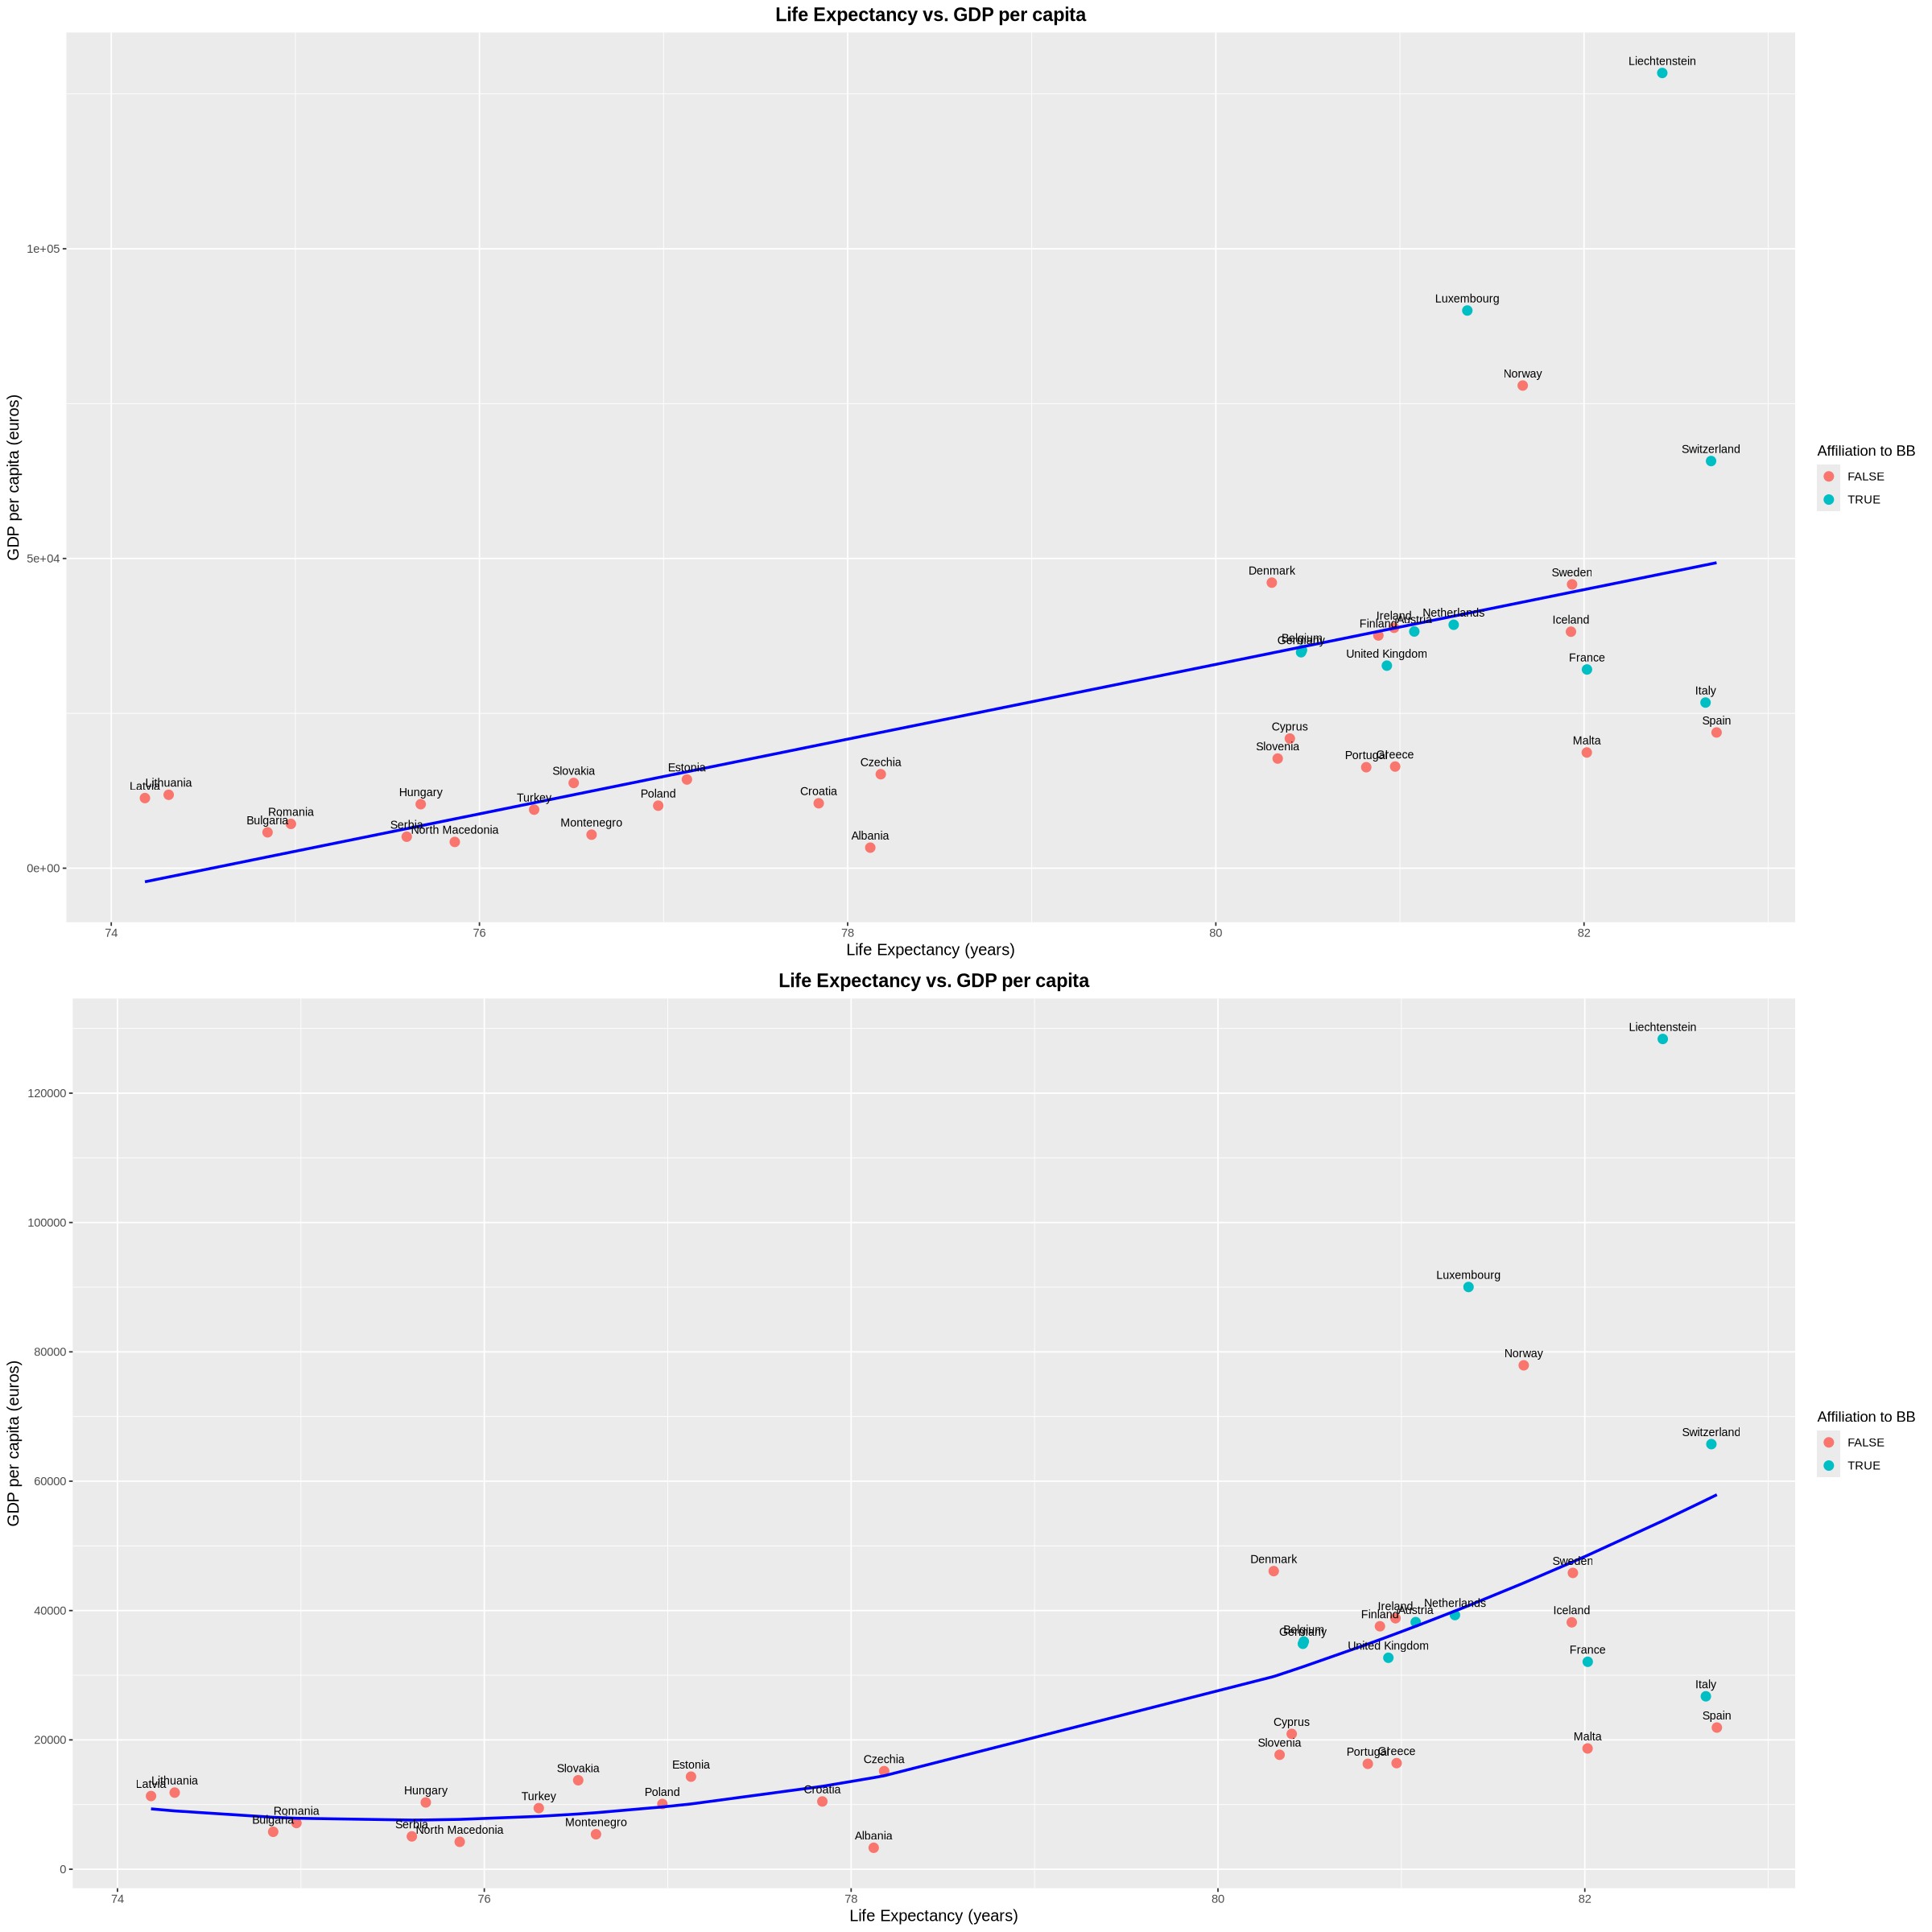

In [27]:
# set up plot size
options(repr.plot.width = 20, repr.plot.height=20)
plot_grid(le_lin_plot, le_poly_plot, nrow=2)

Visually we see that using polynomial function, the data are better described by the independent variable.

#### Education Index

In [28]:
fit_ei_lin <- lm(GDPpc~EI, data=data)
summary(fit_ei_lin)


Call:
lm(formula = GDPpc ~ EI, data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-23257 -15052  -4441   4305 103731 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   -72818      50016  -1.456   0.1543  
EI            119707      58844   2.034   0.0496 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 25390 on 35 degrees of freedom
Multiple R-squared:  0.1057,	Adjusted R-squared:  0.08019 
F-statistic: 4.138 on 1 and 35 DF,  p-value: 0.04955


In [29]:
fit_ei_poly <- lm(GDPpc~poly(EI, 2), data=data)
summary(fit_ei_poly)


Call:
lm(formula = GDPpc ~ poly(EI, 2), data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-24947 -15953  -2215   4872 101546 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)     28576       4205   6.796 8.13e-08 ***
poly(EI, 2)1    51642      25579   2.019   0.0514 .  
poly(EI, 2)2   -17586      25579  -0.688   0.4964    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 25580 on 34 degrees of freedom
Multiple R-squared:  0.118,	Adjusted R-squared:  0.06612 
F-statistic: 2.274 on 2 and 34 DF,  p-value: 0.1183


With this regressor, we see that the adjusted R-squared descreased. Let's assess visually:

In [30]:
# gather data for scatterplots by combining predictions and dataset into one dataframe

# get predictions
fit_ei_lin_pred <- predict(fit_ei_lin, interval="prediction")
fit_ei_poly_pred <- predict(fit_ei_poly, interval="prediction")

# combine predictions with data
data_fit_ei_lin <- cbind(data, fit_ei_lin_pred)
data_fit_ei_poly <- cbind(data, fit_ei_poly_pred)

# create plots
ei_lin_plot <- ggplot(data_fit_ei_lin, aes(x=EI, y=GDPpc)) +
    geom_point(aes(col=BB_entry), size=3) +
    geom_line(aes(y=fit), color='blue', size=1) +                          # regression curve
    labs_ei + text + scale + theme

# create plots
ei_poly_plot <- ggplot(data_fit_ei_poly, aes(x=EI, y=GDPpc)) +
    geom_point(aes(col=BB_entry), size=3) +
    geom_line(aes(y=fit), color='blue', size=1) +                          # regression curve
    labs_ei + text + scale + theme

Warning message in predict.lm(fit_ei_lin, interval = "prediction"):
“predictions on current data refer to _future_ responses
”
Warning message in predict.lm(fit_ei_poly, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


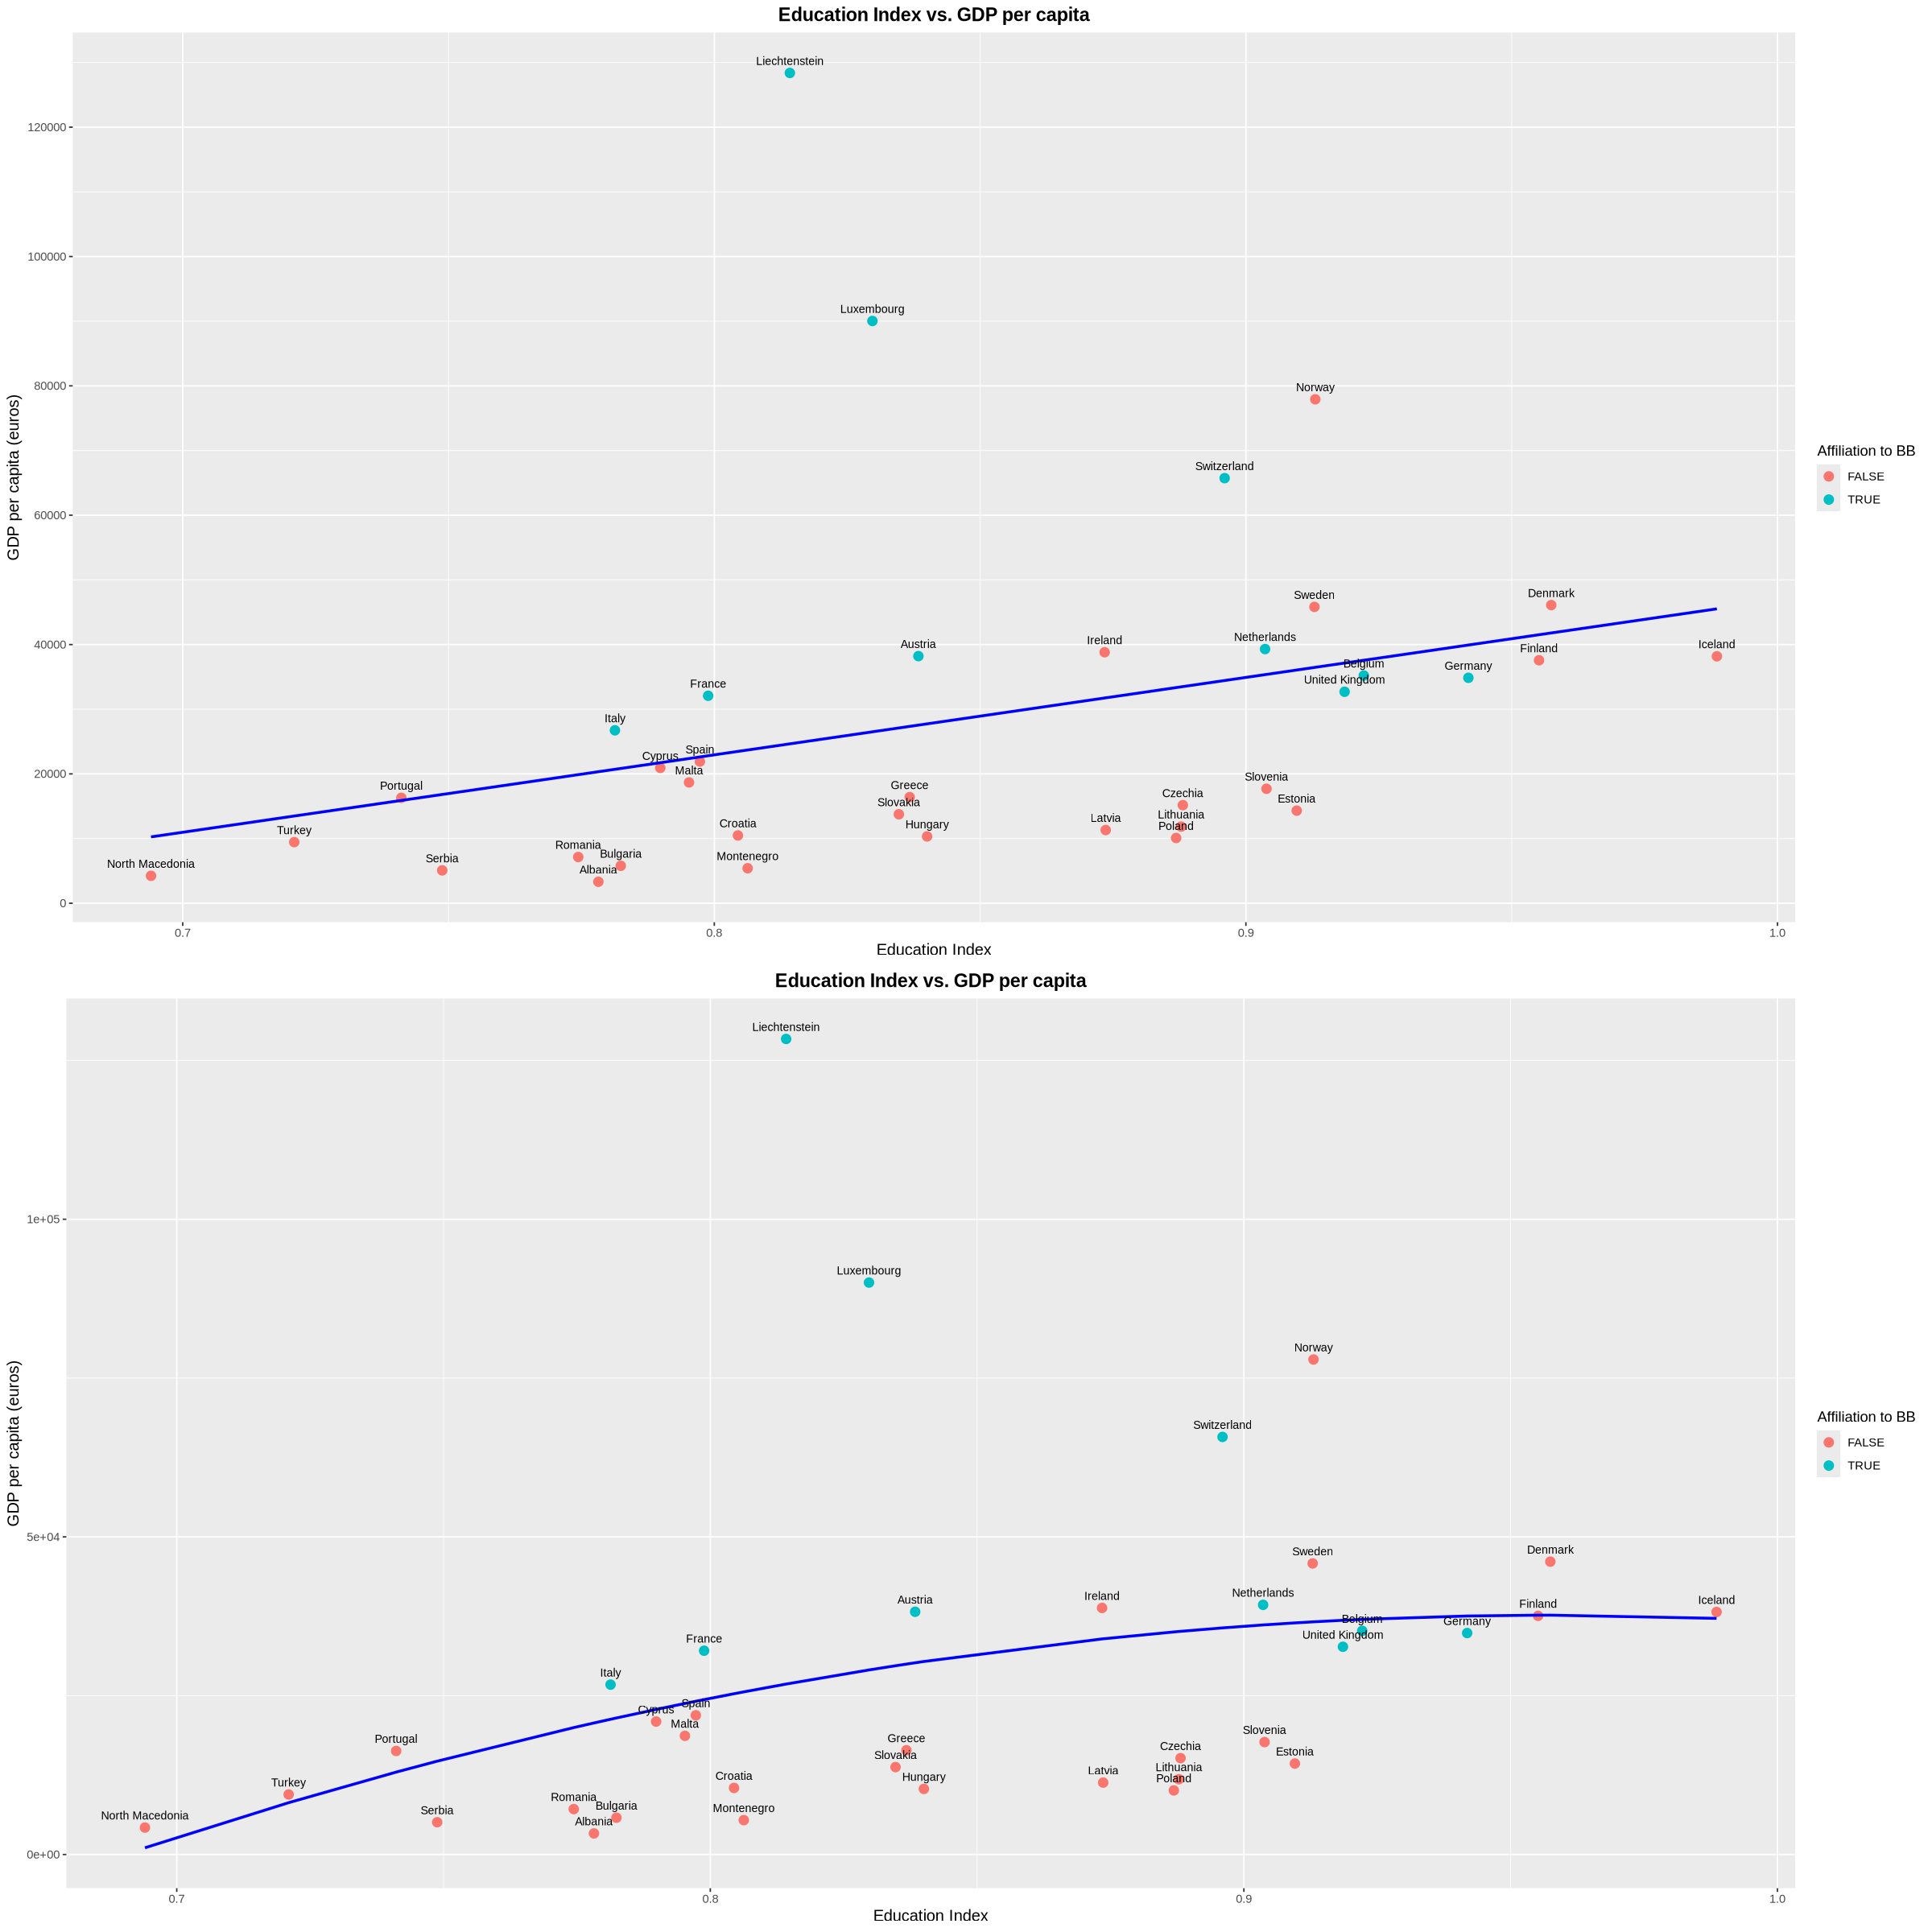

In [31]:
# set up plot size
options(repr.plot.width = 20, repr.plot.height=20)
plot_grid(ei_lin_plot, ei_poly_plot, nrow=2)

The polynomial fnction does not help much here. Instead, because of the outliers, its middle is shifted towards them, which is not good. 

Thus, with this regressor we will not use polynomial function.

#### Net Factor Income from Abroad per capita

In [32]:
fit_nfiapc_lin <- lm(GDPpc~NFIApc, data=data)
summary(fit_nfiapc_lin)


Call:
lm(formula = GDPpc ~ NFIApc, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-14782.6  -3188.8    239.7   3494.1  13192.5 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 28901.643   1095.712   26.38   <2e-16 ***
NFIApc         -2.008      0.087  -23.08   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6664 on 35 degrees of freedom
Multiple R-squared:  0.9384,	Adjusted R-squared:  0.9366 
F-statistic: 532.9 on 1 and 35 DF,  p-value: < 2.2e-16


In [33]:
fit_nfiapc_poly <- lm(GDPpc~poly(NFIApc, 2), data=data)
summary(fit_nfiapc_poly)


Call:
lm(formula = GDPpc ~ poly(NFIApc, 2), data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-14425.7  -1848.4    -71.2   3514.9  12810.5 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)         28576       1039   27.51   <2e-16 ***
poly(NFIApc, 2)1  -153842       6319  -24.34   <2e-16 ***
poly(NFIApc, 2)2   -14028       6319   -2.22   0.0332 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6319 on 34 degrees of freedom
Multiple R-squared:  0.9462,	Adjusted R-squared:  0.943 
F-statistic: 298.8 on 2 and 34 DF,  p-value: < 2.2e-16


There is some minor improvement of adjusted R-squared.

In [34]:
# gather data for scatterplots by combining predictions and dataset into one dataframe

# get predictions
fit_nfiapc_lin_pred <- predict(fit_nfiapc_lin, interval="prediction")
fit_nfiapc_poly_pred <- predict(fit_nfiapc_poly, interval="prediction")

# combine predictions with data
data_fit_nfiapc_lin <- cbind(data, fit_nfiapc_lin_pred)
data_fit_nfiapc_poly <- cbind(data, fit_nfiapc_poly_pred)

# create plots
nfiapc_lin_plot <- ggplot(data_fit_nfiapc_lin, aes(x=NFIApc, y=GDPpc)) +
    geom_point(aes(col=BB_entry), size=3) +
    geom_line(aes(y=fit), color='blue', size=1) +                          # regression curve
    labs_nfiapc + text + scale + theme

# create plots
nfiapc_poly_plot <- ggplot(data_fit_nfiapc_poly, aes(x=NFIApc, y=GDPpc)) +
    geom_point(aes(col=BB_entry), size=3) +
    geom_line(aes(y=fit), color='blue', size=1) +                          # regression curve
    labs_nfiapc + text + scale + theme

Warning message in predict.lm(fit_nfiapc_lin, interval = "prediction"):
“predictions on current data refer to _future_ responses
”
Warning message in predict.lm(fit_nfiapc_poly, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


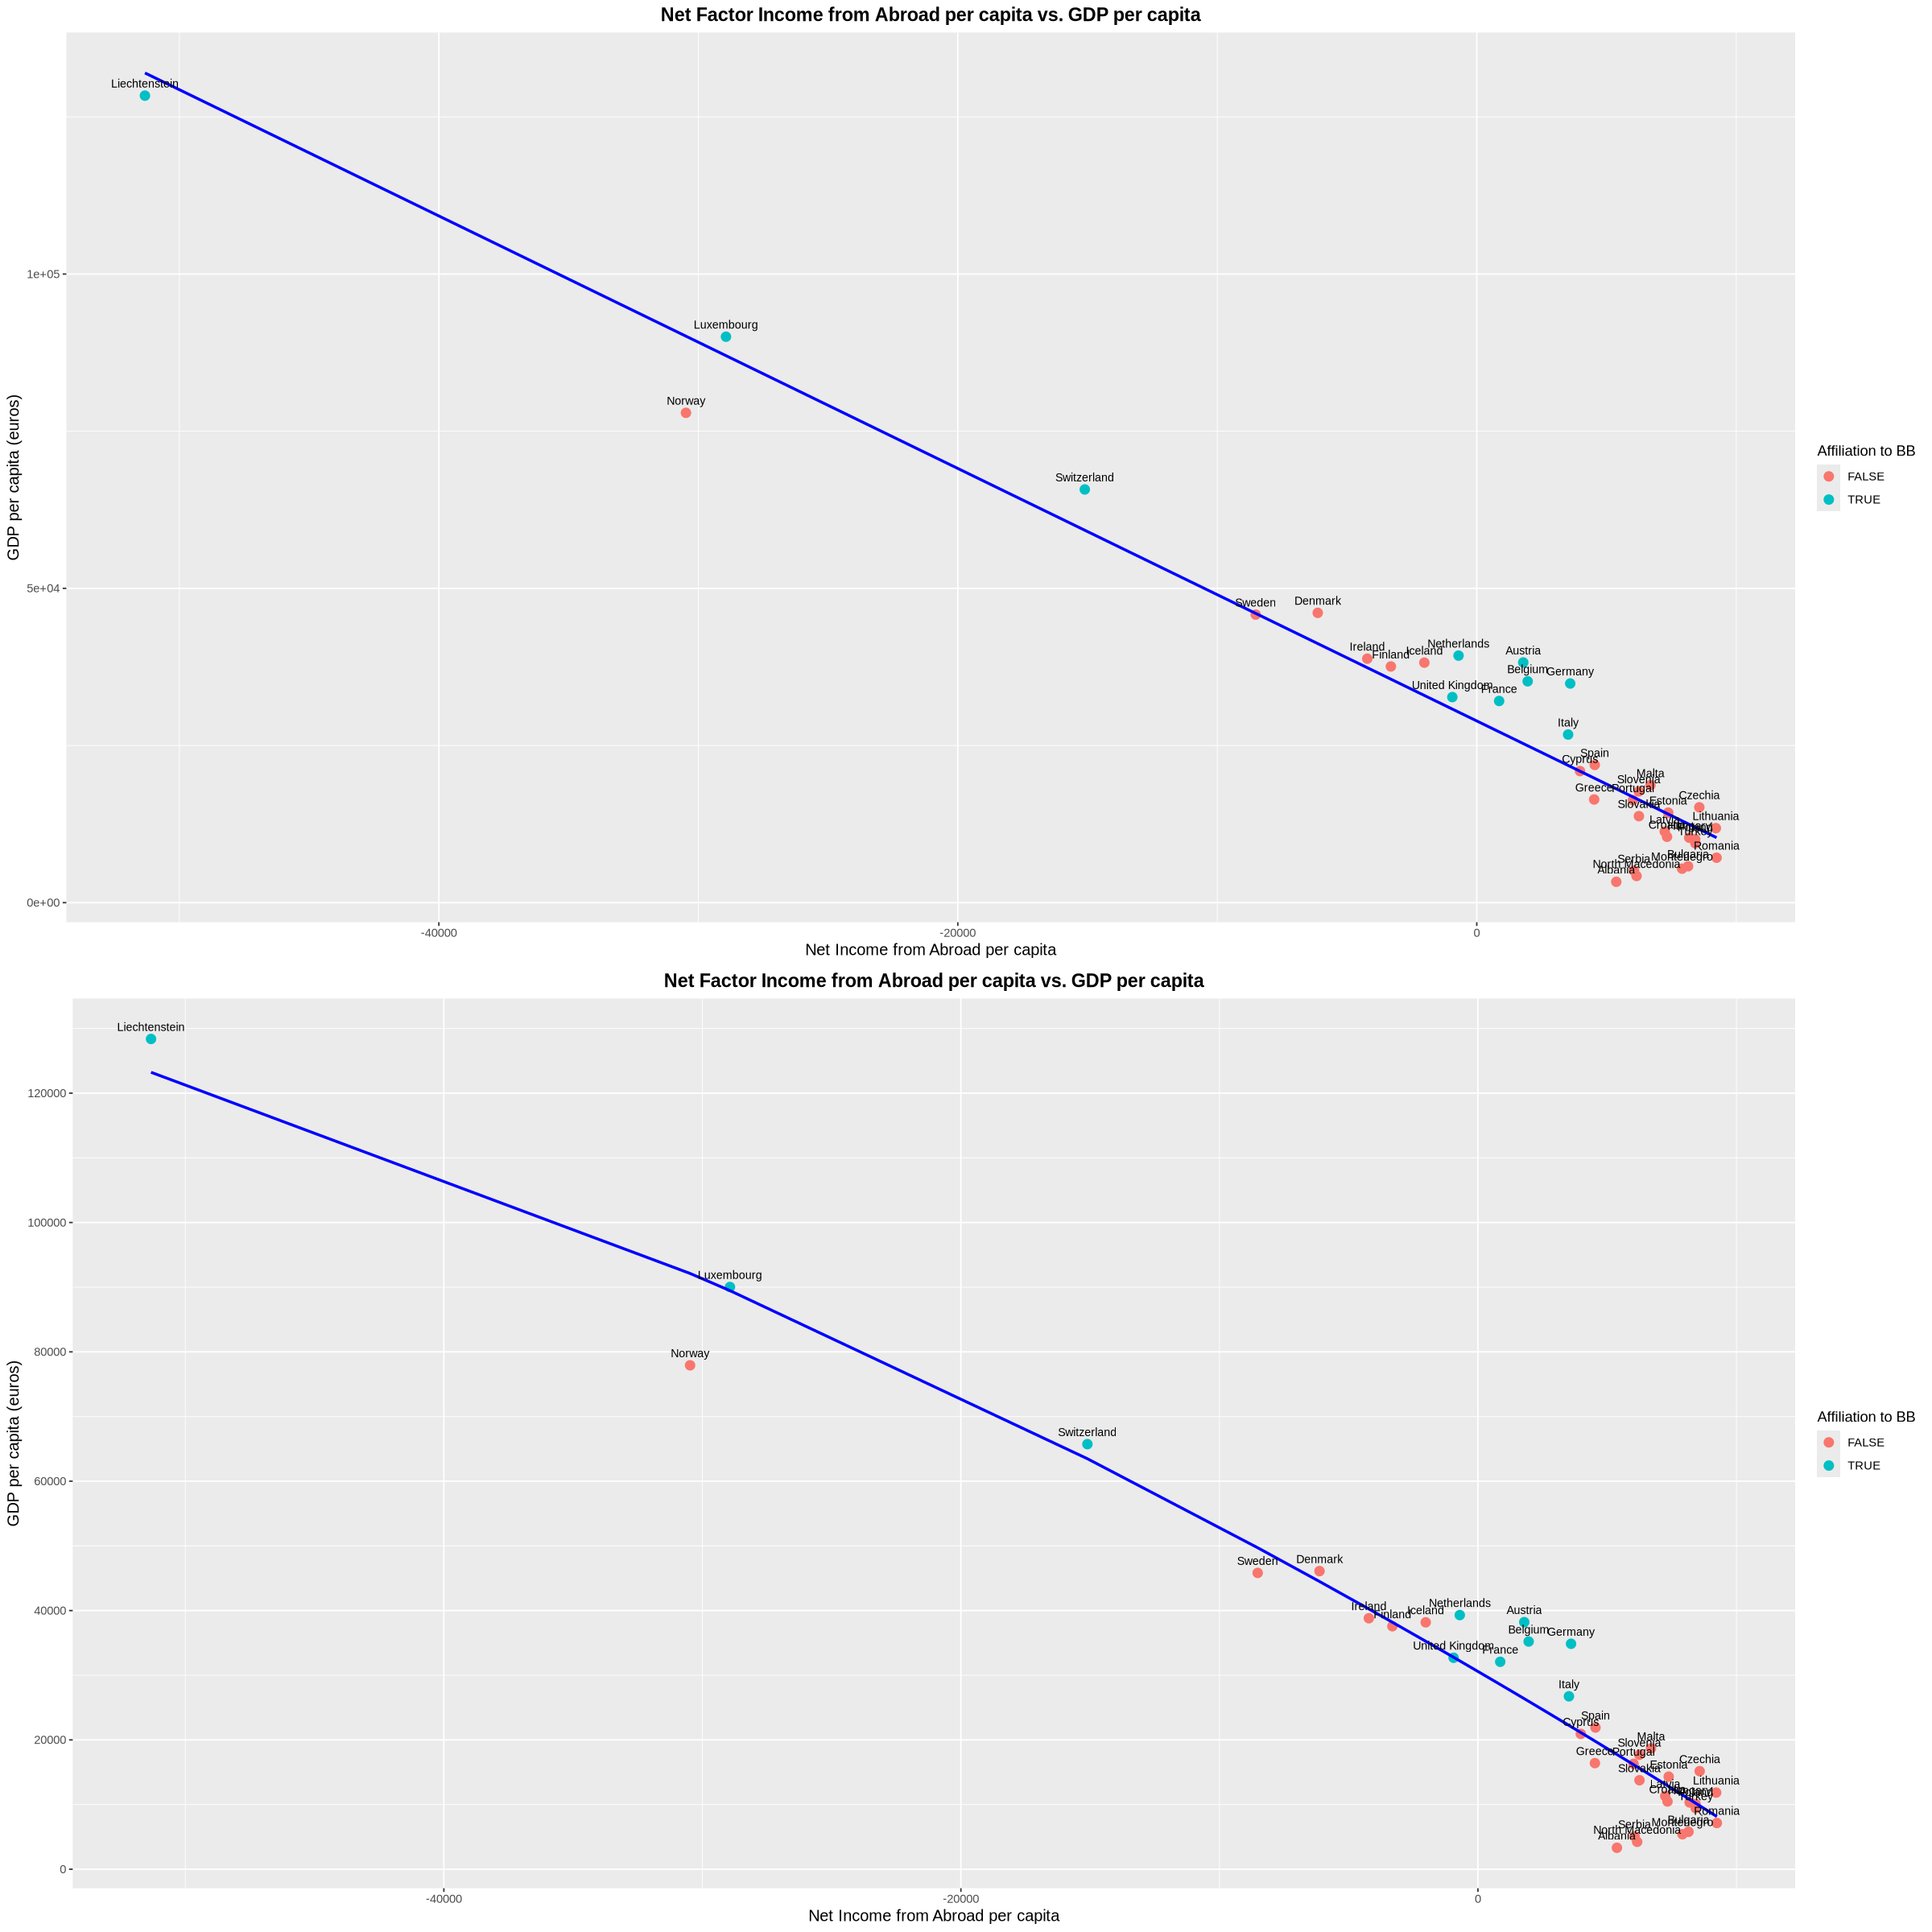

In [35]:
# set up plot size
options(repr.plot.width = 20, repr.plot.height=20)
plot_grid(nfiapc_lin_plot, nfiapc_poly_plot, nrow=2)

While the adjusted R-squared score didn't improve much, we see that data are distributed slightly non-linearly. We will leave the polynomial of this feature in a baseline model.

### Baseline Model

Let's try model with polynomial features:

In [36]:
model <- lm(GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, data = data)
summary(model)


Call:
lm(formula = GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-9204.4 -1564.2    89.4  2276.2  5689.3 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -10460       8375  -1.249  0.22136    
poly(LE, 2)1        17206       5395   3.190  0.00333 ** 
poly(LE, 2)2         3784       3850   0.983  0.33348    
EI                  43527       9852   4.418  0.00012 ***
poly(NFIApc, 2)1  -131100       4815 -27.228  < 2e-16 ***
poly(NFIApc, 2)2     5034       4696   1.072  0.29224    
BB_entryTRUE         8021       1623   4.943 2.74e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3676 on 30 degrees of freedom
Multiple R-squared:  0.9839,	Adjusted R-squared:  0.9807 
F-statistic: 306.1 on 6 and 30 DF,  p-value: < 2.2e-16


Adjusted R-squared score didn't improved at all, though the Multiple R-squared imrpoved very insignificantly. The model has same performance and contains statistically insignificant features - exactly quadratic elements.

Let's add some interactions to the model and see how it will improve - we will add all interactions there:

In [37]:
model <- lm(GDPpc ~ poly(LE, 2) * EI * poly(NFIApc, 2) * BB_entry, data = data)
summary(model)


Call:
lm(formula = GDPpc ~ poly(LE, 2) * EI * poly(NFIApc, 2) * BB_entry, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-5454.4  -238.0     0.0   536.9  4201.0 

Coefficients: (8 not defined because of singularities)
                                                Estimate Std. Error t value
(Intercept)                                      -546016     769152  -0.710
poly(LE, 2)1                                     4502725    5790252   0.778
poly(LE, 2)2                                    -3999594    3379002  -1.184
EI                                                743662     892736   0.833
poly(NFIApc, 2)1                                 9011824   13123101   0.687
poly(NFIApc, 2)2                                -3130879    5109608  -0.613
BB_entryTRUE                                   -25457718   25061264  -1.016
poly(LE, 2)1:EI                                 -5851023    6738225  -0.868
poly(LE, 2)2:EI                                  4705615    3957710   1.1

We see, that with interactions our model improved in terms of R-squared score much, even taking in consideration its immense complexity. 

The only problem is that some of the coefficients are not defined. Reasons for this may be - collinear features or lack of data. Let's remove interactions that cause problems with undefined coefficients:

In [95]:
model <- lm(GDPpc ~
            (poly(LE, 2) * EI * poly(NFIApc,2)) +
            BB_entry + 
            BB_entry * (poly(LE, 2) + poly(NFIApc,2) + EI) +
            BB_entry * poly(LE, 2) * EI,
            data = data)
summary(model)


Call:
lm(formula = GDPpc ~ (poly(LE, 2) * EI * poly(NFIApc, 2)) + BB_entry + 
    BB_entry * (poly(LE, 2) + poly(NFIApc, 2) + EI) + BB_entry * 
    poly(LE, 2) * EI, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-6138.0  -369.1    12.2   559.0  5100.8 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)
(Intercept)                        -229775     667974  -0.344    0.737
poly(LE, 2)1                       3477030    5430686   0.640    0.535
poly(LE, 2)2                      -1439523    2071489  -0.695    0.502
EI                                  344469     760607   0.453    0.659
poly(NFIApc, 2)1                   3423086   11311972   0.303    0.768
poly(NFIApc, 2)2                   -909534    4383760  -0.207    0.839
BB_entryTRUE                       -551472     825757  -0.668    0.518
poly(LE, 2)1:EI                   -4278180    6242864  -0.685    0.507
poly(LE, 2)2:EI                    1721989    2451155   0.703    0.497
p

Now we have model with even higher R-squared. But coefficients are too big, probably there is some multicollinearity between some interactions, also the models probably is overfitted.

For our baseline model we will use the second model - simpler version with polynomial functions. It performs slightly better than the simple linear model without funcions, but choosing the final model we still can just reduce coefficients and get back to the simple linear model.

In [102]:
baseline <- lm(GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, data = data)

## Outliers

Exploration of data points that are:
- outliers - prediction values don't follow the main trend.
- leverages - data points that may follow the main trend, but they lie far away from the main clusters of data.
- both outliers and leverages.

### Outliers in Regressors Data

Our task is to explore outliers in the dataset. We will use boxplots and violin plots to get some insights:

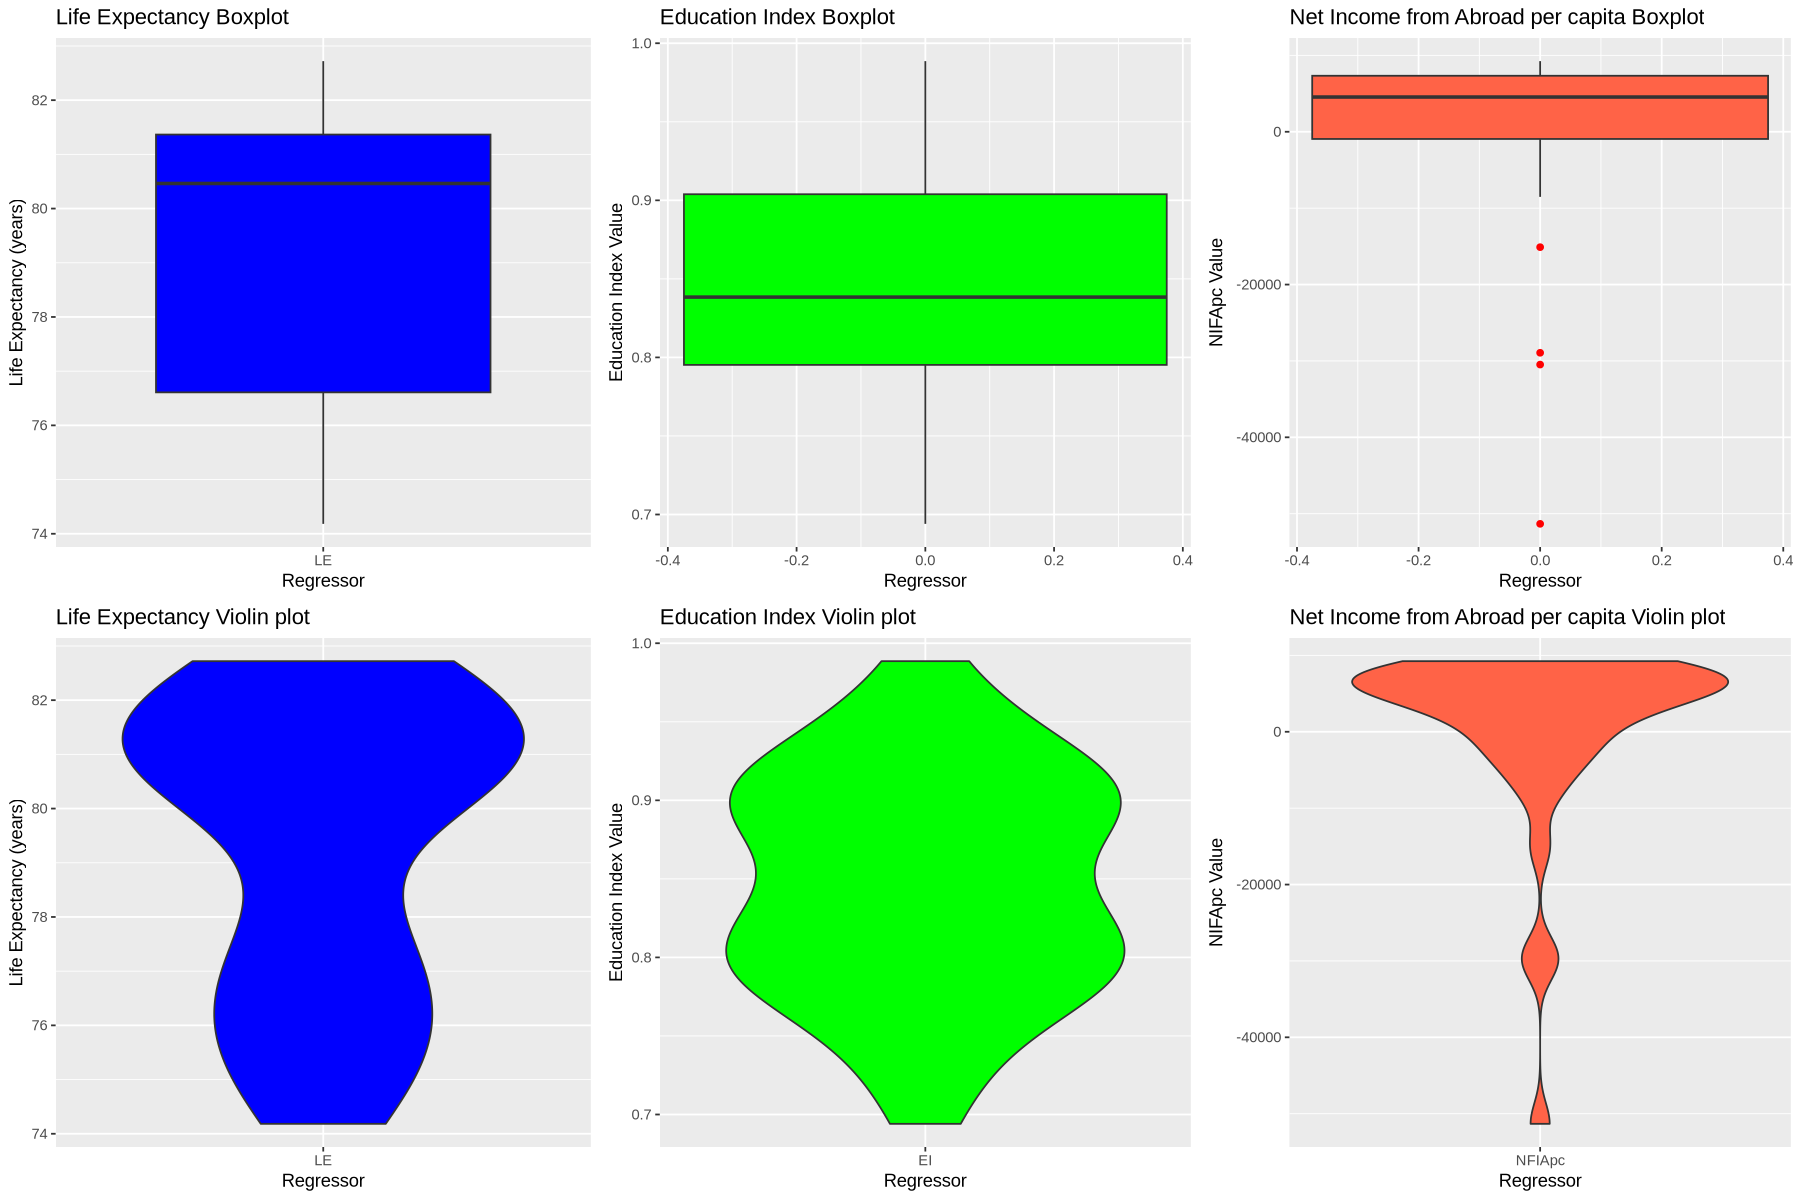

In [38]:
# set up plot size
options(repr.plot.width = 15, repr.plot.height=10)

# Create individual ggplots for each regressor

boxplot_LE <- ggplot(data, aes(x="LE", y=LE)) + 
    geom_boxplot(fill="blue", outlier.color="red") +
    labs(title="Life Expectancy Boxplot", x="Regressor", y="Life Expectancy (years)")
violin_LE <- ggplot(data, aes(x="LE", y=LE))+
    geom_violin(fill= "blue") +
    labs(title="Life Expectancy Violin plot", x="Regressor", y="Life Expectancy (years)")

boxplot_EI <- ggplot(data, aes(y=EI)) + 
    geom_boxplot(fill="green", outlier.color="red") +
    labs(title="Education Index Boxplot", x="Regressor", y="Education Index Value")
violin_EI <- ggplot(data, aes(x="EI", y=EI)) +
    geom_violin(fill= "green") + 
    labs(title="Education Index Violin plot", x="Regressor", y="Education Index Value")

boxplot_NFIApc <- ggplot(data, aes(y=NFIApc)) + 
    geom_boxplot(fill="tomato", outlier.color="red") +
    labs(title="Net Income from Abroad per capita Boxplot", x="Regressor", y="NIFApc Value")
violin_NFIApc <- ggplot(data, aes(x="NFIApc", y=NFIApc)) +
    geom_violin(fill= "tomato") +
    labs(title="Net Income from Abroad per capita Violin plot", x="Regressor", y="NIFApc Value")

# Arrange the plots in a grid
plot_grid(boxplot_LE, boxplot_EI, boxplot_NFIApc,
             violin_LE, violin_EI, violin_NFIApc,
             nrow = 2, ncol = 3)
             

**Net Income from Abroad per capita** has some outliers from the regressor's main distribution. 

Looking at the scatter plot **Net Income from Abroad per capita vs. GDP per capita** we observe, that those data points follow the the trend and the regression curve can be layed effectively through those data points and the main trend. Then we cannot consider them as outliers, but as leverages, because their `x` values are far from the main cluster of points. In this case those data points are not problematic.

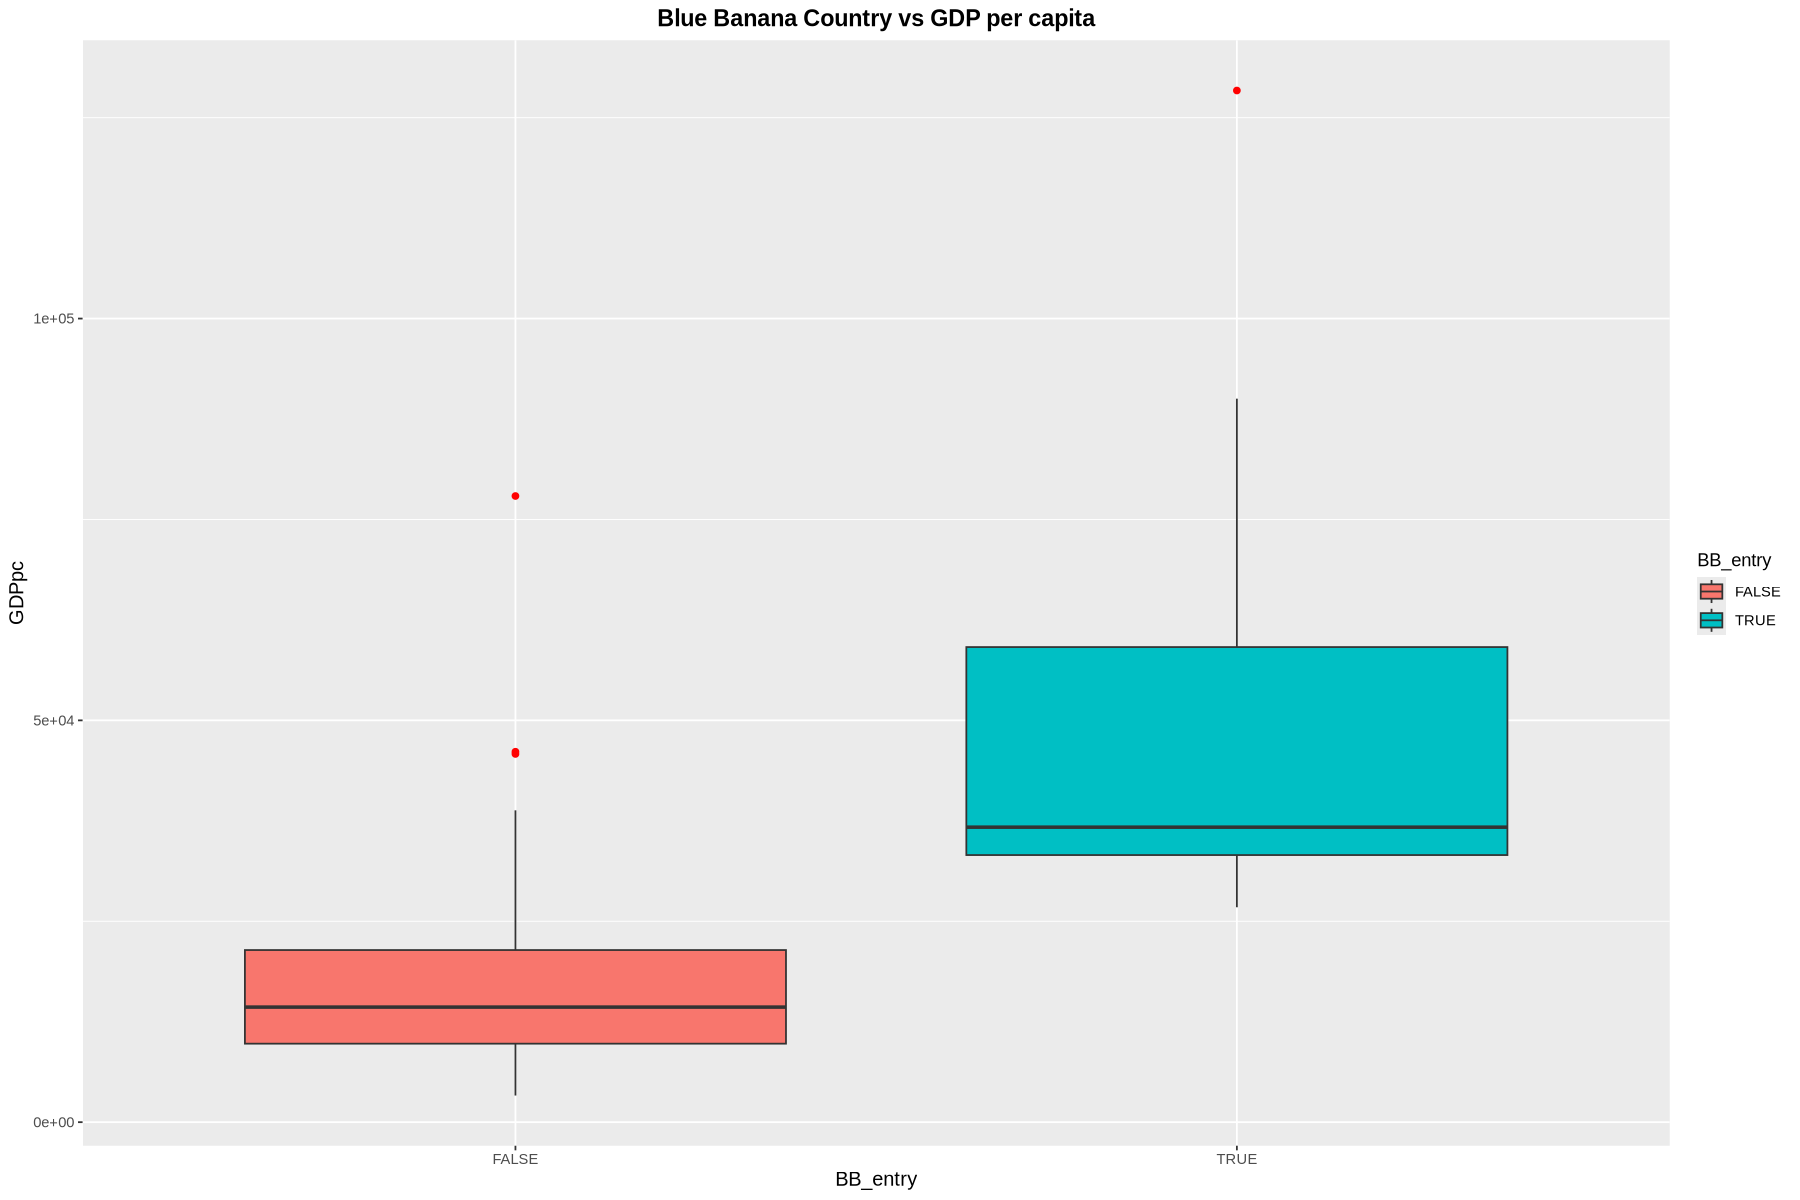

In [73]:
ggplot(data, aes(x=BB_entry, y=GDPpc, fill=BB_entry)) +
  geom_boxplot(outlier.color='red') +
  labs(title="Blue Banana Country vs GDP per capita") +
  theme

On the plot we observe, that among the non-BB countries there are 3 outliers - Norway, Denmark and Sweden. We can observe that on the **Ranking by countries by GDPpc level** plot presented earlier. In this case we know that those are outliers, because their prediction values lie far from the main group.

Observing other scatterplots - **Life Expectancy vs. GDP per capita** and **Education Index vs. GDP per capita** we see some of the most influential outliers:
 - Lichtensteing
 - Luxemburg
 - Norway

Visually we can consider them as influential. But other regressors have their influence on the prediction too and we need to look at it as whole.

### Outliers in Residuals

We will assess which outliers we are interested to remove from the dataset using the Cook's distance metric: 

$$
D_i = \frac{\sum_{j=1}^n (\hat{Y}_j - \hat{Y}_{j(i)})^2}{k \frac{S_e}{n-k}},
$$

where $k$ is number of regressors, $S_e$ is residual sum of squares, $\hat{Y}_j$ is prediction of $Y_j$ and $\hat{Y}_{j(i)}$ prediction of $Y_j$ with removing the $i$-th data point.

In other words, we remove a data point and look the change. The change is the distance for the i-th data point. The higher the distance is, the more influential the point is.

To determine the cutoff value, there are different methods, like median point of F-distribution and other formula - we will use the 4 / n formula, where n is the number of observations.

In [58]:
# plots sizes
options(repr.plot.width=15, repr.plot.height=10)

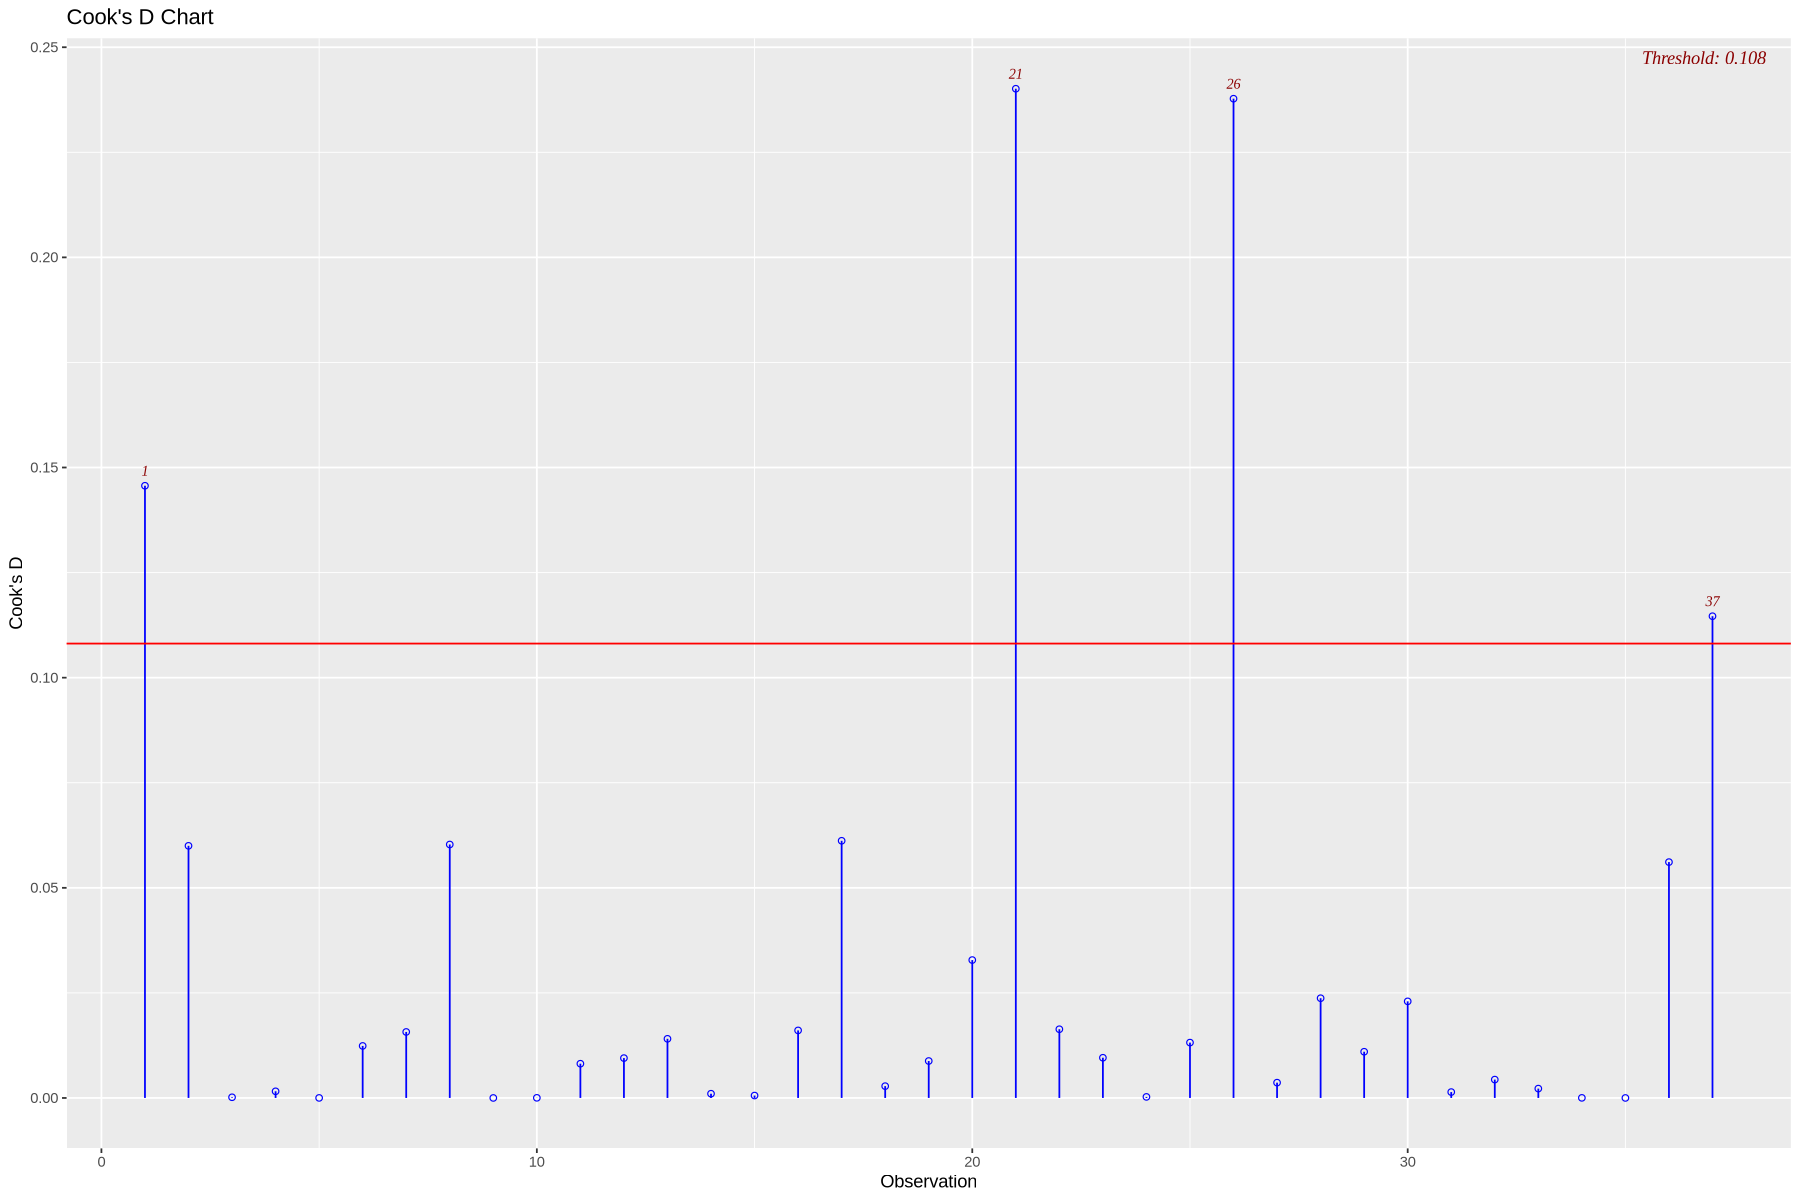

In [103]:
ols_plot_cooksd_chart(baseline)

Datapoints 17, 19 may be influential:



In [104]:
data[c(21, 26, 1, 37),]

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
21,Luxembourg,90030,81.366,0.8297409,-28933.9761,TRUE
26,Norway,77920,81.667,0.9130506,-30476.4766,FALSE
1,Albania,3320,78.123,0.7781896,5376.9032,FALSE
37,United Kingdom,32700,80.929,0.9185661,-941.5821,TRUE


The **Liechtensteing** is both visually and metrically influential outlier - we will remove it and check again the results.

In [105]:
# remove observation 19
data_filtered <- data[-21,]
# reset indexes
row.names(data_filtered) <- NULL

In [107]:
baseline <- lm(GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, data = data_filtered)
summary(baseline)


Call:
lm(formula = GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, 
    data = data_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-8699.3 -1419.3   229.6  1585.6  6321.5 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -16283       8374  -1.944 0.061596 .  
poly(LE, 2)1        20233       5418   3.734 0.000819 ***
poly(LE, 2)2         5019       3760   1.335 0.192297    
EI                  48745       9877   4.935 3.04e-05 ***
poly(NFIApc, 2)1  -117261       4718 -24.854  < 2e-16 ***
poly(NFIApc, 2)2     8305       4785   1.736 0.093248 .  
BB_entryTRUE         7364       1599   4.604 7.61e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3534 on 29 degrees of freedom
Multiple R-squared:  0.983,	Adjusted R-squared:  0.9795 
F-statistic:   280 on 6 and 29 DF,  p-value: < 2.2e-16


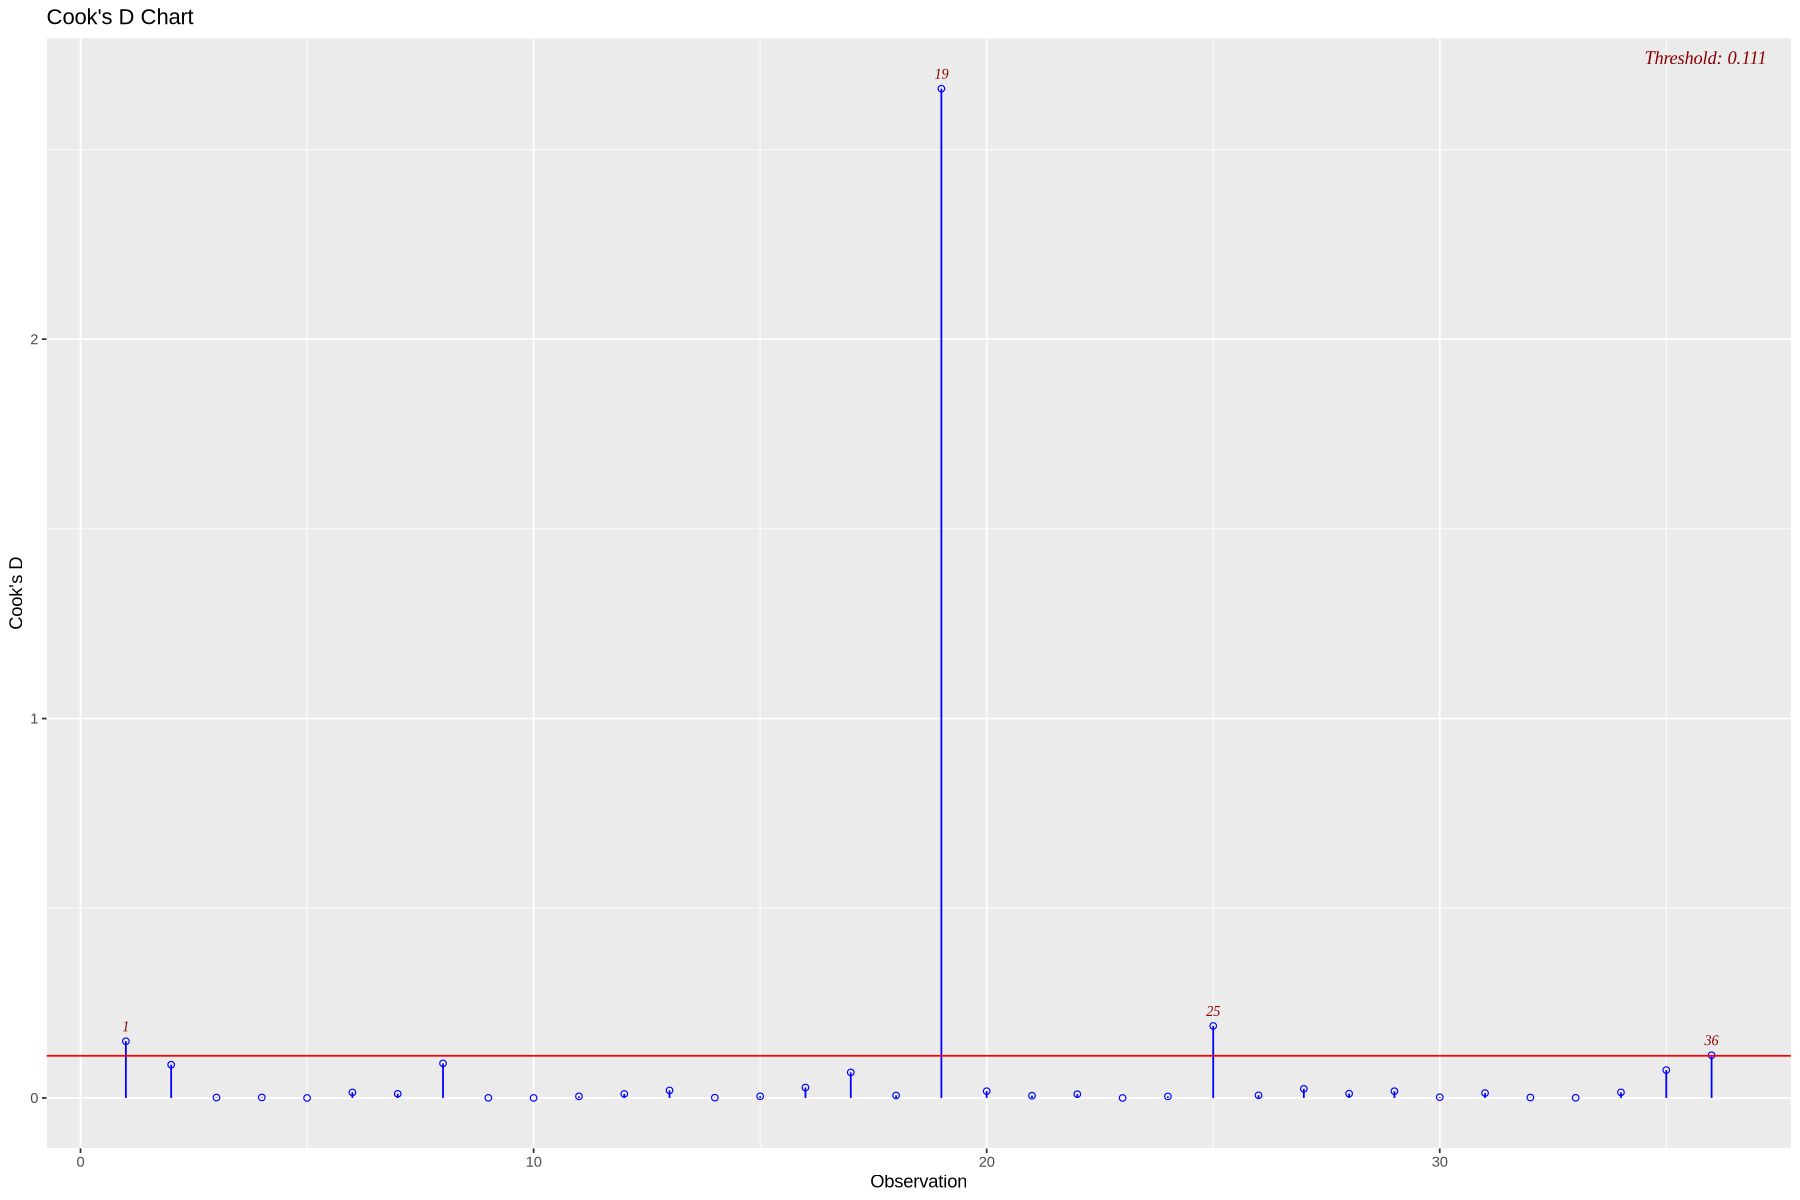

In [108]:
ols_plot_cooksd_chart(baseline)

In [109]:
data_filtered[c(19),]

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
19,Liechtenstein,128380,82.425,0.8142102,-51327.34,TRUE


The next outlier is the Norway, which makes sense looking again at **Blue Banana Country vs GDP per capita** and the **Ranking of countries by GDPpc level** plots.

In [110]:
# remove observation 19
data_filtered <- data_filtered[-19,]
# reset indexes
row.names(data_filtered) <- NULL

In [111]:
baseline <- lm(GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, data = data_filtered)
summary(baseline)


Call:
lm(formula = GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, 
    data = data_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-8947.0 -1527.0  -232.6  1961.6  6435.2 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -18024       8362  -2.156 0.039862 *  
poly(LE, 2)1        17750       5469   3.245 0.003035 ** 
poly(LE, 2)2         4998       3649   1.369 0.181729    
EI                  47666       9838   4.845 4.23e-05 ***
poly(NFIApc, 2)1   -72284       5213 -13.867 4.58e-14 ***
poly(NFIApc, 2)2    -1015       4616  -0.220 0.827576    
BB_entryTRUE         6783       1657   4.093 0.000327 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3505 on 28 degrees of freedom
Multiple R-squared:  0.968,	Adjusted R-squared:  0.9611 
F-statistic: 141.1 on 6 and 28 DF,  p-value: < 2.2e-16


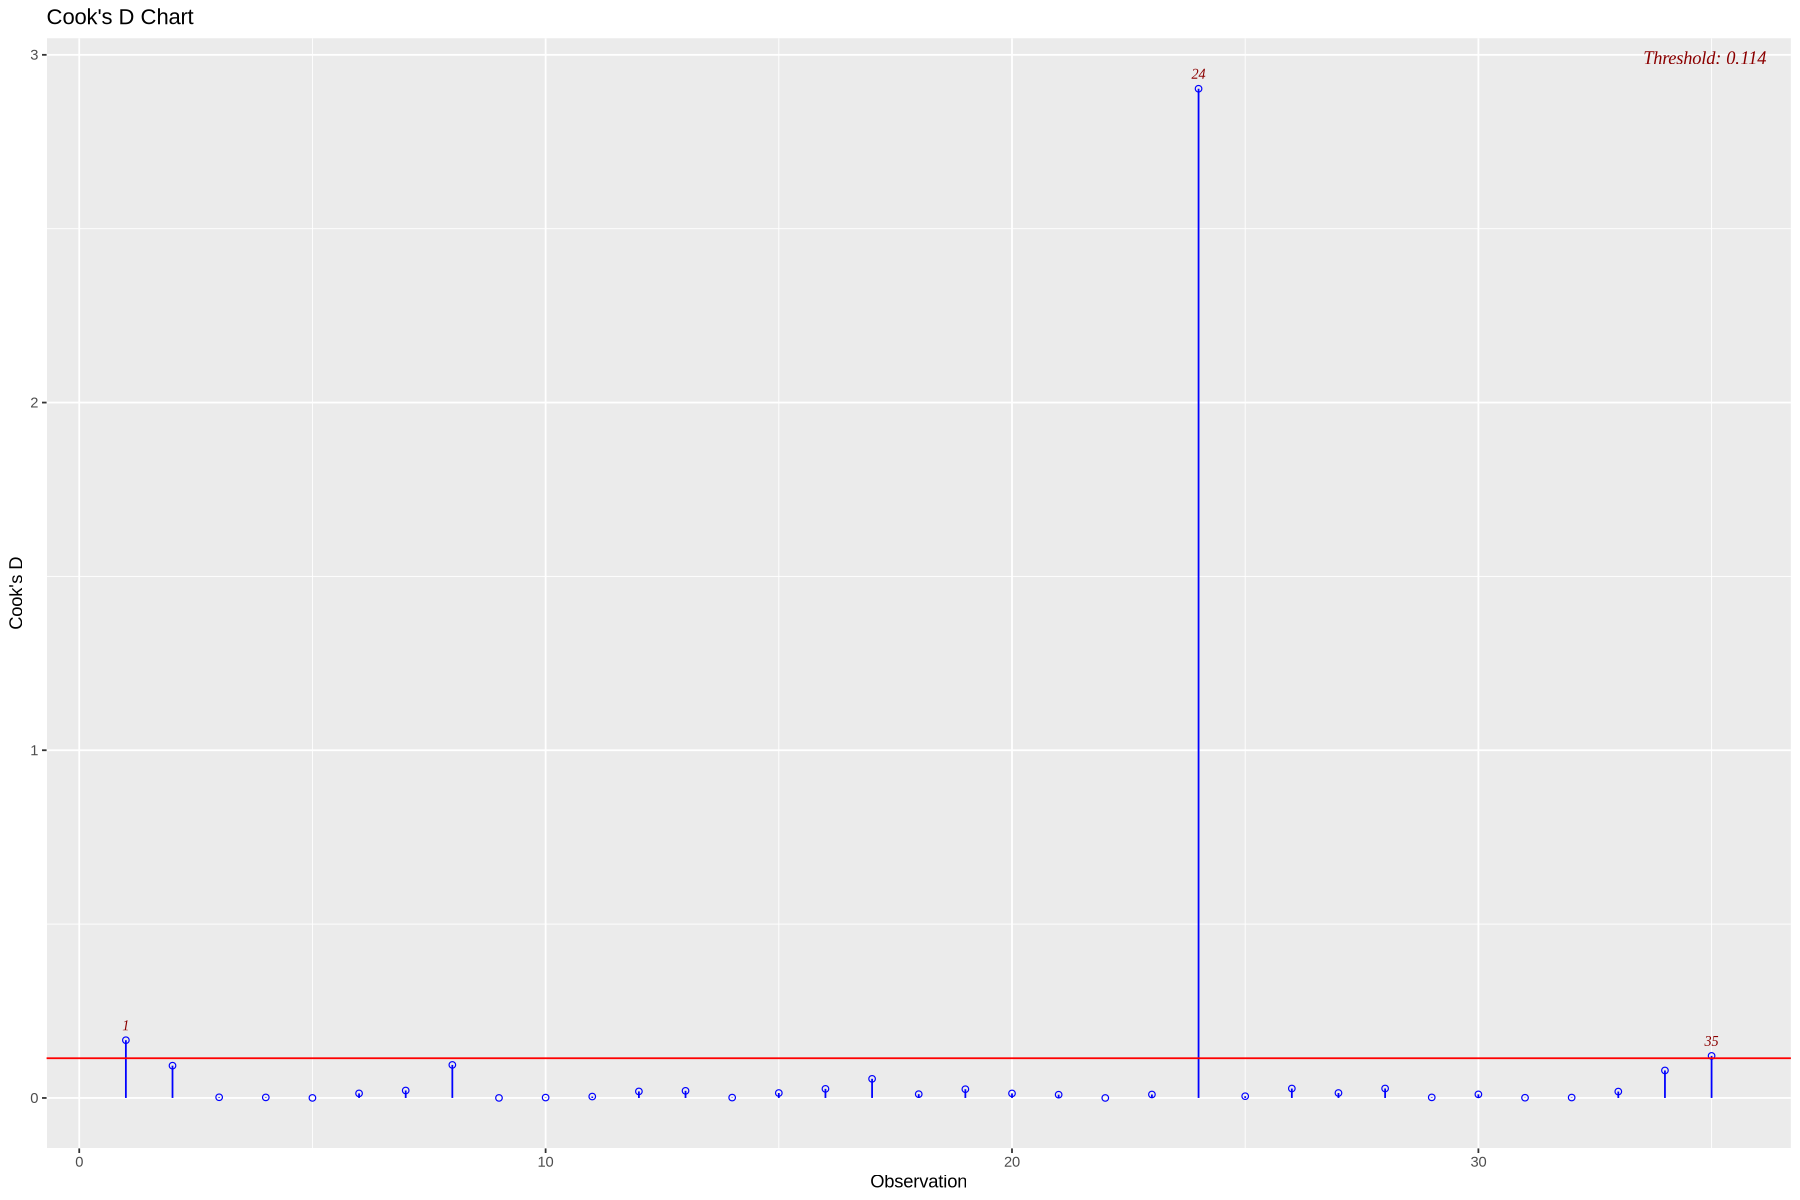

In [112]:
ols_plot_cooksd_chart(baseline)

In [113]:
data_filtered[c(24),]

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
24,Norway,77920,81.667,0.9130506,-30476.48,FALSE


The next point to remove is the **Luxembourg** - looking back at scatterplots, Luxembourgh really is a strong outlier there and high leverage. We will remove it.

In [114]:
# remove observation 19
data_filtered <- data_filtered[-24,]
# reset indexes
row.names(data_filtered) <- NULL

In [115]:
baseline <- lm(GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, data = data_filtered)
summary(baseline)


Call:
lm(formula = GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, 
    data = data_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-8895.9 -1307.8  -133.8  1811.7  6861.1 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -19759       8308  -2.378 0.024737 *  
poly(LE, 2)1        19293       5611   3.438 0.001913 ** 
poly(LE, 2)2         3900       3756   1.038 0.308296    
EI                  47881       9796   4.888 4.12e-05 ***
poly(NFIApc, 2)1   -51023       5669  -9.000 1.29e-09 ***
poly(NFIApc, 2)2     3933       4239   0.928 0.361744    
BB_entryTRUE         6831       1650   4.139 0.000306 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3490 on 27 degrees of freedom
Multiple R-squared:  0.9576,	Adjusted R-squared:  0.9481 
F-statistic: 101.5 on 6 and 27 DF,  p-value: < 2.2e-16


Interesting observation is that by removing some points, some features started to show their significance for the model.

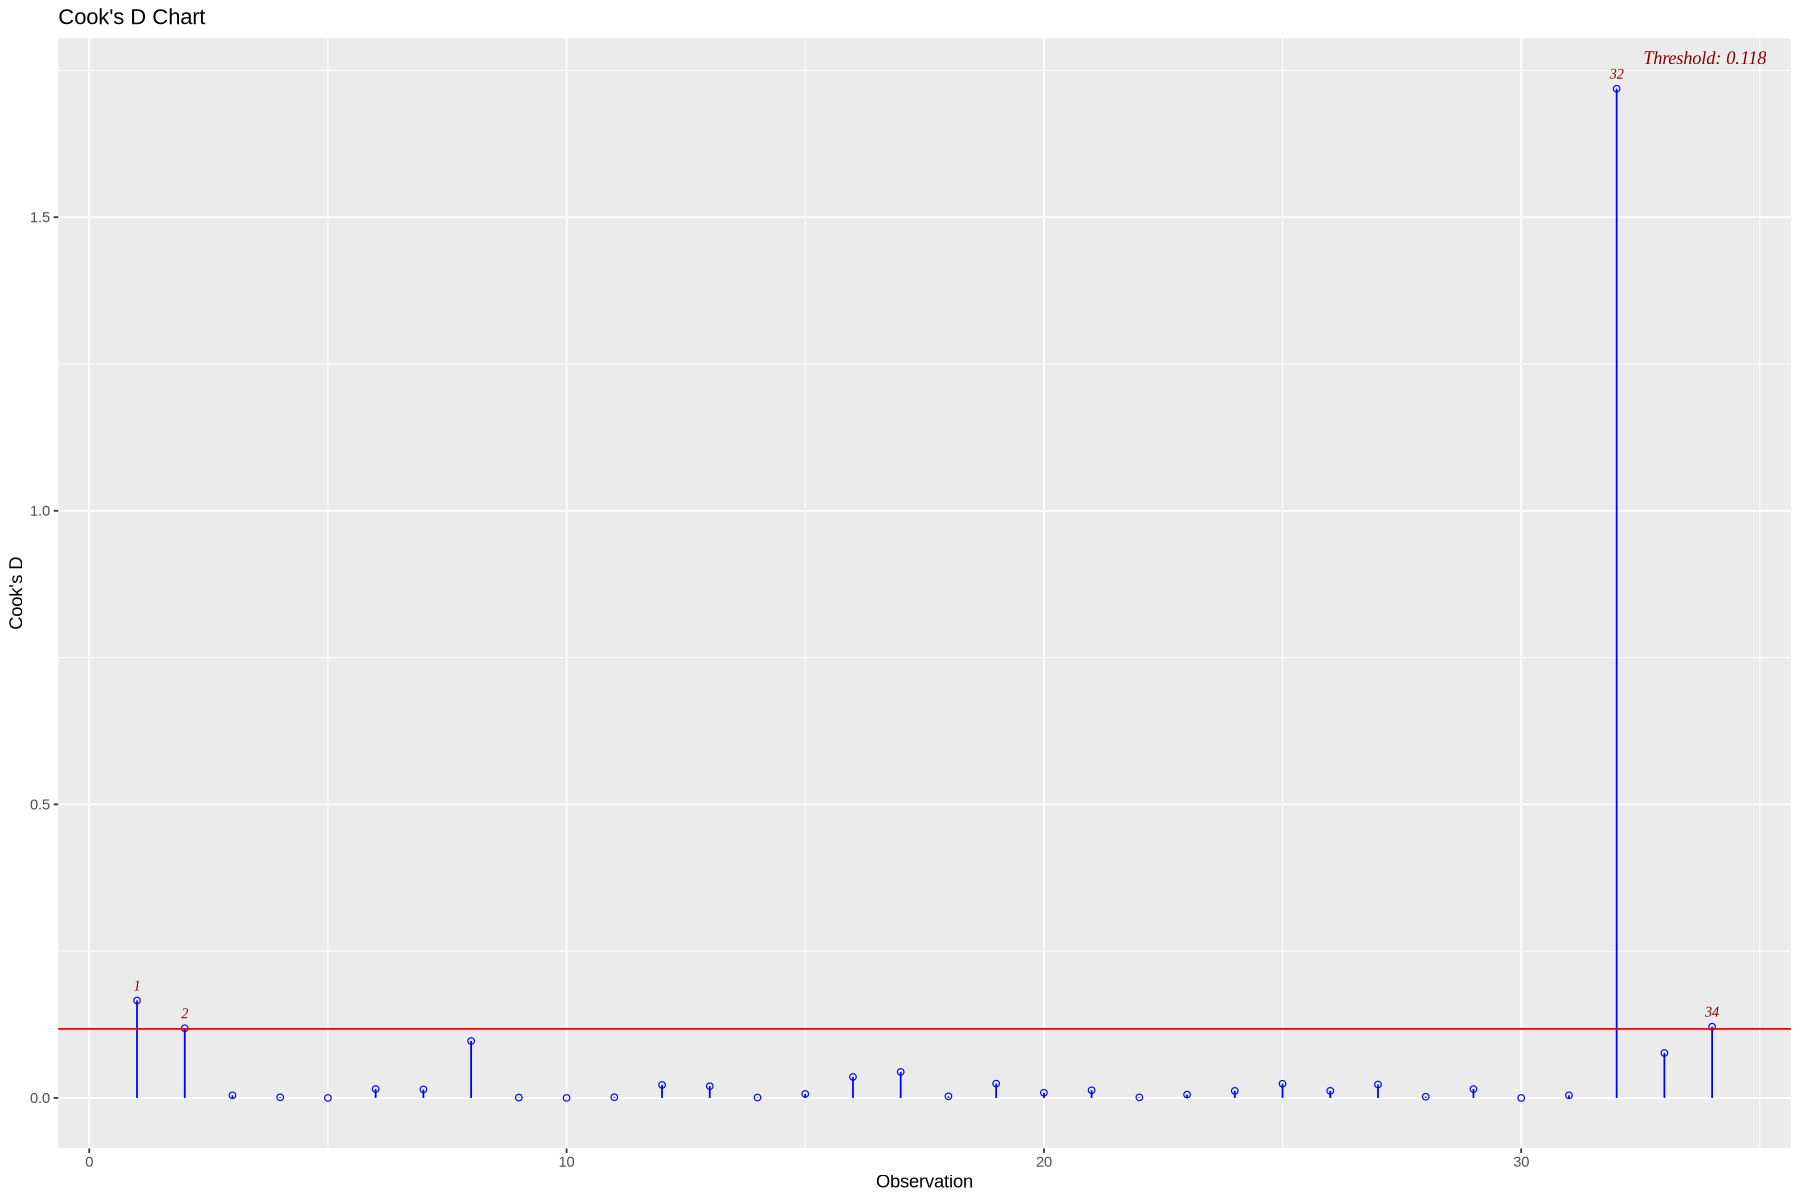

In [116]:
ols_plot_cooksd_chart(baseline)

In [117]:
data_filtered[32,]

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
32,Switzerland,65730,82.69,0.8959988,-15106.32,TRUE


In [119]:
simple_linear <- lm(GDPpc ~ LE + EI + NFIApc + BB_entry, data = data_filtered)
summary(simple_linear)


Call:
lm(formula = GDPpc ~ LE + EI + NFIApc + BB_entry, data = data_filtered)

Residuals:
     Min       1Q   Median       3Q      Max 
-10241.8  -1391.6    150.9   2163.3   6130.0 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -8.937e+04  2.636e+04  -3.391 0.002028 ** 
LE            9.938e+02  3.114e+02   3.192 0.003387 ** 
EI            4.404e+04  9.572e+03   4.601 7.69e-05 ***
NFIApc       -1.670e+00  1.584e-01 -10.545 1.96e-11 ***
BB_entryTRUE  6.942e+03  1.640e+03   4.233 0.000212 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3520 on 29 degrees of freedom
Multiple R-squared:  0.9536,	Adjusted R-squared:  0.9472 
F-statistic:   149 on 4 and 29 DF,  p-value: < 2.2e-16


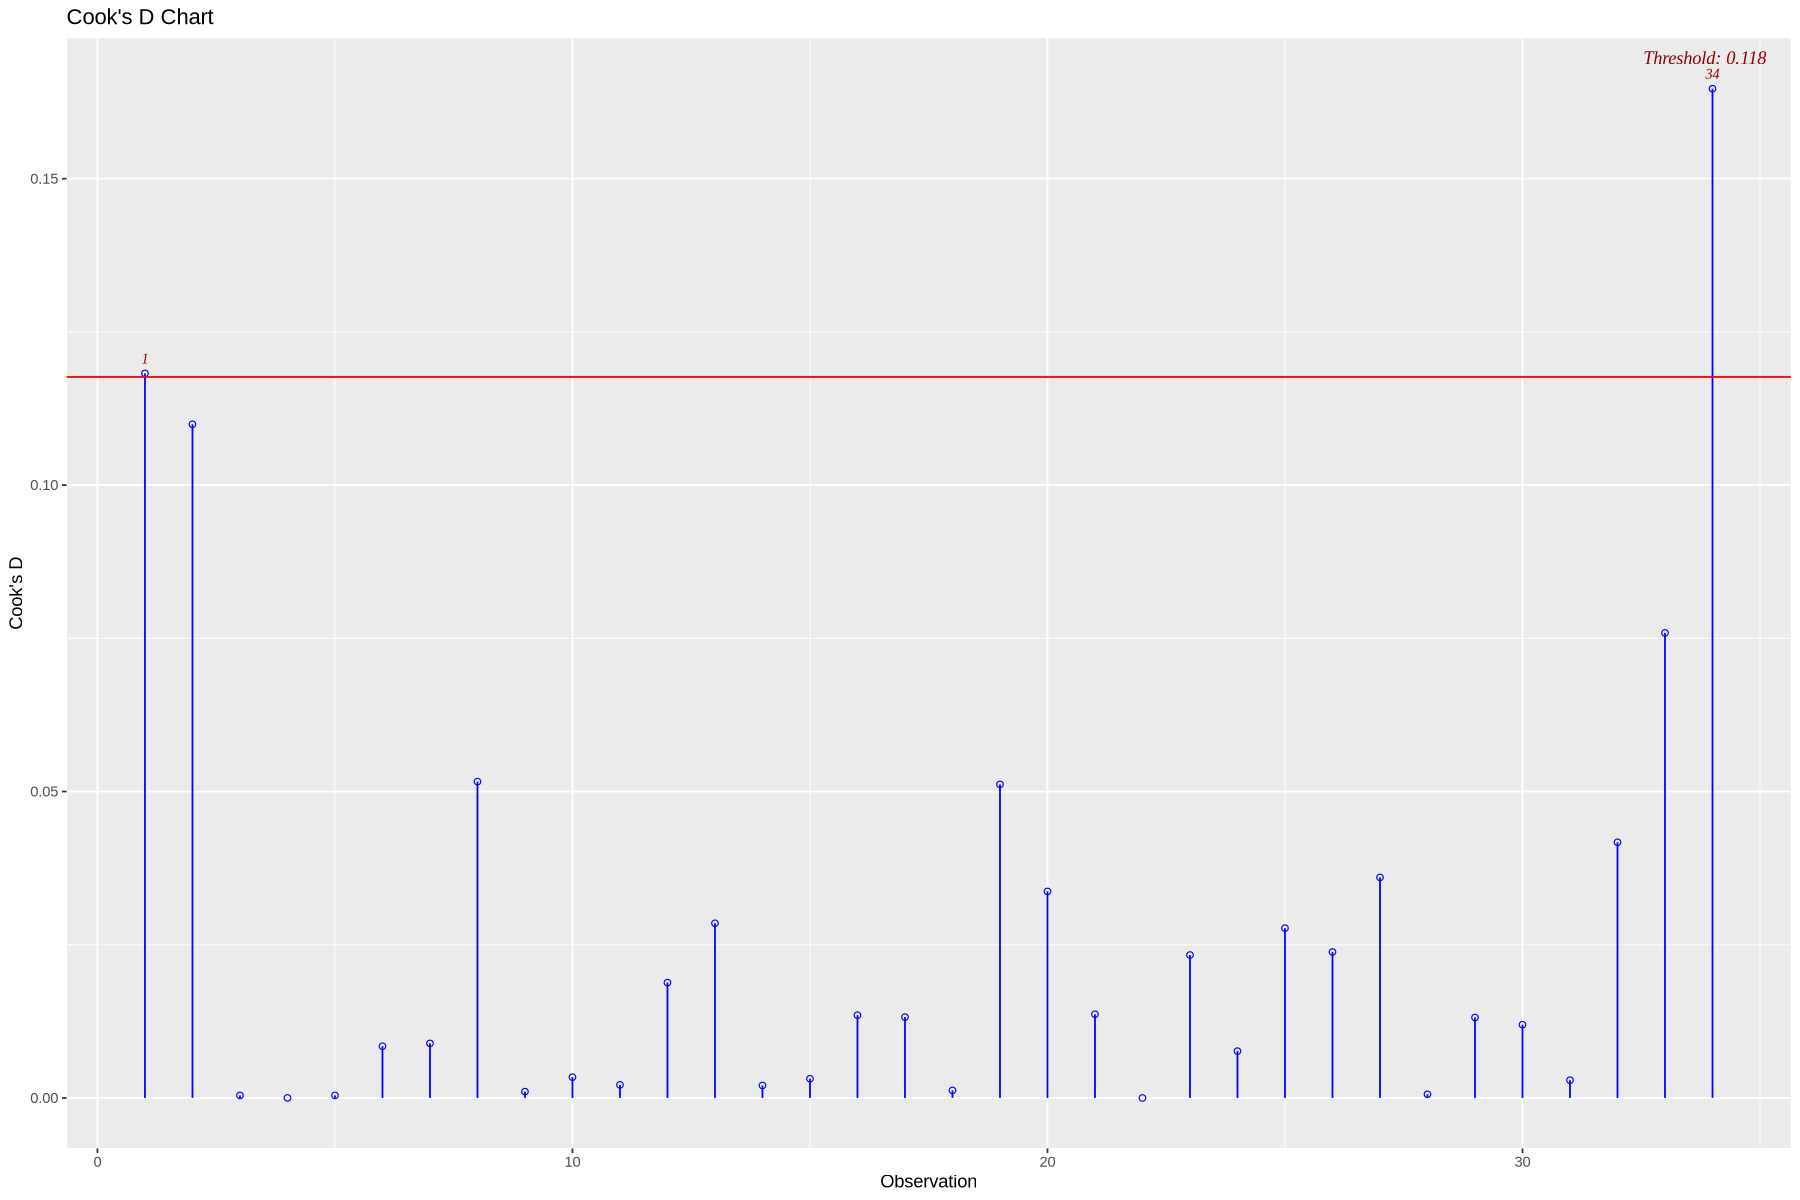

In [120]:
ols_plot_cooksd_chart(simple_linear)

In [121]:
data_filtered[34,]

,country,GDPpc,LE,EI,NFIApc,BB_entry
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
34,United Kingdom,32700,80.929,0.9185661,-941.5821,TRUE


## Multicollinearity

To test multicollinearity we will use the VIF method.

In [84]:
model <- lm(GDPpc ~ LE + EI + NFIApc + BB_entry, data = data_filtered)
ols_coll_diag(model)

Tolerance and Variance Inflation Factor
---------------------------------------
     Variables Tolerance      VIF
1           LE 0.5024318 1.990320
2           EI 0.7496180 1.334013
3       NFIApc 0.4628138 2.160696
4 BB_entryTRUE 0.7529168 1.328168


Eigenvalue and Condition Index
------------------------------
    Eigenvalue Condition Index    intercept           LE           EI
1 3.5665282400        1.000000 4.037283e-05 4.615208e-05 4.199957e-04
2 1.0469263549        1.845716 1.841172e-07 8.929037e-09 1.445778e-06
3 0.3824895796        3.053606 7.139697e-05 8.895501e-05 1.029963e-03
4 0.0037691621       30.760999 1.907324e-02 3.312936e-02 9.558103e-01
5 0.0002866634      111.541553 9.808148e-01 9.667355e-01 4.273834e-02
      NFIApc BB_entryTRUE
1 0.00861499  0.014235727
2 0.15828065  0.278734937
3 0.36493073  0.609514437
4 0.08839276  0.003442492
5 0.37978086  0.094072407

In the **Tolerance and Variance Inflation Factor** table we see the VIF values for each feature. The rule of thumb is that when VIF is higher than 4 or 5, we should look closely and make furhter inspections. If VIF is higher than 10, it indicates strong multicollinearity.

In our case, we see that VIF values are less that 4, that is, between untransformed features there is no multicollinearity.

## Model Assumptions Tests

Before we will venture for final model selection, let's check premises of our current baseline model:

- heteroscedacity
- normality of residuals

In [123]:
ols_test_breusch_pagan(baseline)


 Breusch Pagan Test for Heteroskedasticity
 -----------------------------------------
 Ho: the variance is constant            
 Ha: the variance is not constant        

              Data                
 ---------------------------------
 Response : GDPpc 
 Variables: fitted values of GDPpc 

        Test Summary          
 -----------------------------
 DF            =    1 
 Chi2          =    0.03548284 
 Prob > Chi2   =    0.8505875 

The test fails to reject the null hypothesis that variance is constant. So we will work with this model as with constant variance of residuals.

In [124]:
ols_test_normality(baseline)

-----------------------------------------------
       Test             Statistic       pvalue  
-----------------------------------------------
Shapiro-Wilk              0.9756         0.6308 
Kolmogorov-Smirnov        0.1037         0.8214 
Cramer-von Mises          2.951          0.0000 
Anderson-Darling          0.3057         0.5483 
-----------------------------------------------

We will consider the Shapiro-Wilk test - because it is very good for small datasets under 50 data points.
In the result we fail to reject the null hypothesis that residuals are not normal.

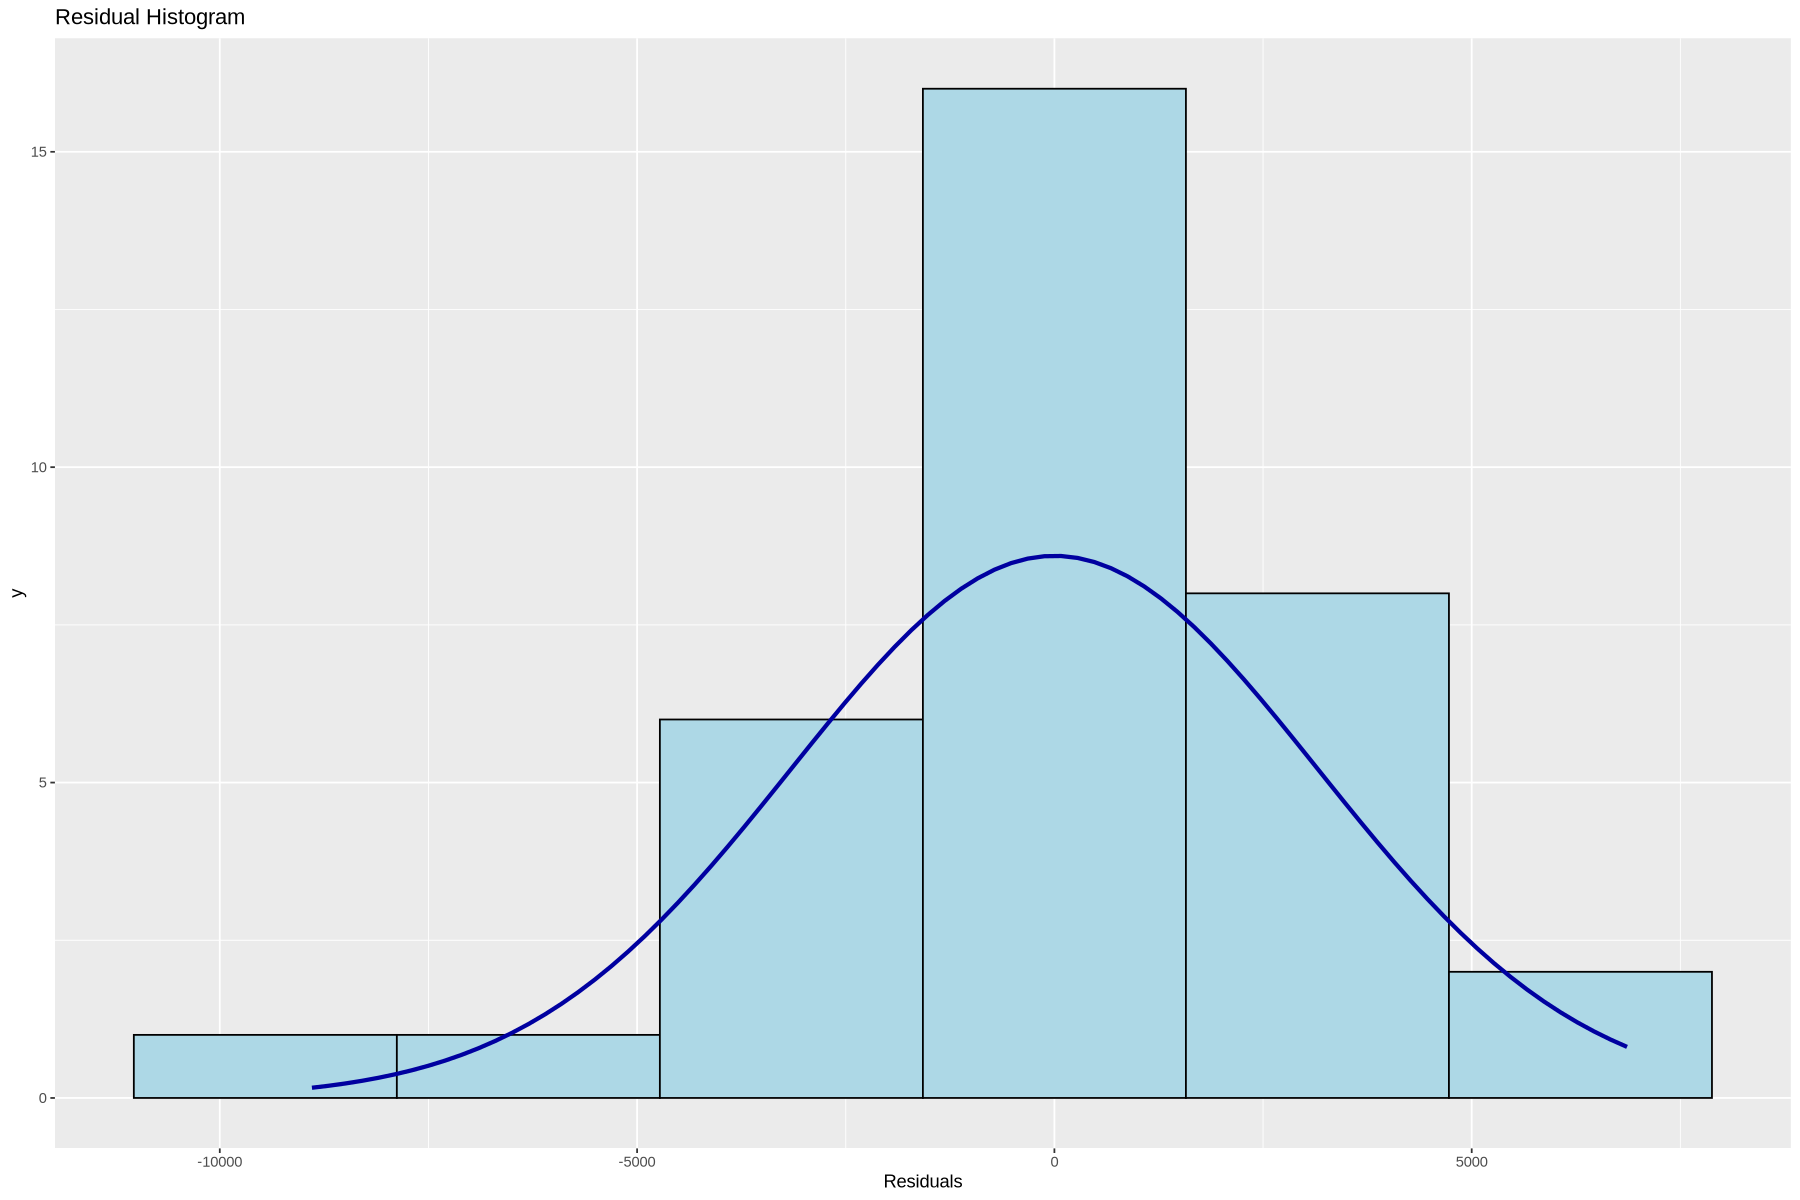

In [125]:
ols_plot_resid_hist(baseline)

## Final Model

In [126]:
final <- lm(GDPpc ~
            poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry,
            data = data_filtered)
summary(final)


Call:
lm(formula = GDPpc ~ poly(LE, 2) + EI + poly(NFIApc, 2) + BB_entry, 
    data = data_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-8895.9 -1307.8  -133.8  1811.7  6861.1 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -19759       8308  -2.378 0.024737 *  
poly(LE, 2)1        19293       5611   3.438 0.001913 ** 
poly(LE, 2)2         3900       3756   1.038 0.308296    
EI                  47881       9796   4.888 4.12e-05 ***
poly(NFIApc, 2)1   -51023       5669  -9.000 1.29e-09 ***
poly(NFIApc, 2)2     3933       4239   0.928 0.361744    
BB_entryTRUE         6831       1650   4.139 0.000306 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3490 on 27 degrees of freedom
Multiple R-squared:  0.9576,	Adjusted R-squared:  0.9481 
F-statistic: 101.5 on 6 and 27 DF,  p-value: < 2.2e-16


In [142]:
attach(data_filtered)
step(lm(GDPpc ~1),
     scope=list(lower=~1,
     upper=~LE + I(LE^2) + EI + NFIApc + I(NFIApc^2) + BB_entry))
detach(data_filtered)

Start:  AIC=656.3
GDPpc ~ 1

              Df  Sum of Sq        RSS    AIC
+ NFIApc       1 6613238615 1132029597 592.91
+ I(LE^2)      1 4425070823 3320197388 629.50
+ LE           1 4405296176 3339972036 629.70
+ EI           1 2998968491 4746299721 641.65
+ BB_entry     1 2585698174 5159570038 644.48
<none>                      7745268212 656.30
+ I(NFIApc^2)  1   27318765 7717949447 658.18

Step:  AIC=592.91
GDPpc ~ NFIApc

              Df  Sum of Sq        RSS    AIC
+ BB_entry     1  393424605  738604992 580.39
+ I(LE^2)      1  276164924  855864673 585.40
+ LE           1  274613828  857415769 585.46
+ EI           1  266354454  865675143 585.79
+ I(NFIApc^2)  1   72576894 1059452703 592.66
<none>                      1132029597 592.91
- NFIApc       1 6613238615 7745268212 656.30

Step:  AIC=580.39
GDPpc ~ NFIApc + BB_entry

              Df  Sum of Sq        RSS    AIC
+ EI           1  253100998  485503994 568.13
+ I(LE^2)      1  117463274  621141718 576.50
+ LE           1


Call:
lm(formula = GDPpc ~ NFIApc + BB_entry + EI + I(LE^2))

Coefficients:
 (Intercept)        NFIApc  BB_entryTRUE            EI       I(LE^2)  
  -50850.374        -1.666      6919.556     44154.504         6.383  


In [144]:
final <- lm(GDPpc ~ NFIApc + BB_entry + EI + I(LE^2), data=data_filtered)
summary(final)


Call:
lm(formula = GDPpc ~ NFIApc + BB_entry + EI + I(LE^2), data = data_filtered)

Residuals:
     Min       1Q   Median       3Q      Max 
-10190.3  -1439.3    169.1   2182.3   6145.5 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -5.085e+04  1.528e+04  -3.327 0.002395 ** 
NFIApc       -1.666e+00  1.584e-01 -10.520 2.06e-11 ***
BB_entryTRUE  6.920e+03  1.637e+03   4.226 0.000216 ***
EI            4.415e+04  9.551e+03   4.623 7.22e-05 ***
I(LE^2)       6.383e+00  1.982e+00   3.221 0.003147 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3512 on 29 degrees of freedom
Multiple R-squared:  0.9538,	Adjusted R-squared:  0.9475 
F-statistic: 149.8 on 4 and 29 DF,  p-value: < 2.2e-16


In [145]:
comparison <- lm(GDPpc ~ NFIApc + BB_entry + EI + LE, data=data_filtered)
summary(comparison)


Call:
lm(formula = GDPpc ~ NFIApc + BB_entry + EI + LE, data = data_filtered)

Residuals:
     Min       1Q   Median       3Q      Max 
-10241.8  -1391.6    150.9   2163.3   6130.0 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -8.937e+04  2.636e+04  -3.391 0.002028 ** 
NFIApc       -1.670e+00  1.584e-01 -10.545 1.96e-11 ***
BB_entryTRUE  6.942e+03  1.640e+03   4.233 0.000212 ***
EI            4.404e+04  9.572e+03   4.601 7.69e-05 ***
LE            9.938e+02  3.114e+02   3.192 0.003387 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3520 on 29 degrees of freedom
Multiple R-squared:  0.9536,	Adjusted R-squared:  0.9472 
F-statistic:   149 on 4 and 29 DF,  p-value: < 2.2e-16


## References


used in outliers section for understanding difference between outliers and leverages - https://online.stat.psu.edu/stat462/node/170/#:~:text=In%20short%3A,is%20particularly%20high%20or%20low.


https://en.wikipedia.org/wiki/Cook%27s_distance

https://people.duke.edu/~rnau/testing.htm